In [2]:
import os, sys
import tkinter as tk
from  tkinter import *
from tkinter import filedialog
import zipfile

C:\Users\Kedaresh\AppData\Local\Temp\ipykernel_18072\3101640538.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  IMG_DTYPE = np.float


Default GPU Device: /device:GPU:0
931
(16, 256, 256, 3) (16, 256, 256, 1)
4
2
(256, 256, 1)
cm....
static\pics
 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://192.168.56.1:5000 (Press CTRL+C to quit)
192.168.56.1 - - [29/May/2022 16:38:28] "GET / HTTP/1.1" 200 -
192.168.56.1 - - [29/May/2022 16:38:28] "GET /static/pics/test_in.jpg HTTP/1.1" 200 -
192.168.56.1 - - [29/May/2022 16:38:28] "GET /static/LT.jpg HTTP/1.1" 404 -
192.168.56.1 - - [29/May/2022 16:39:07] "GET /results HTTP/1.1" 200 -
192.168.56.1 - - [29/May/2022 16:39:07] "GET /static/pics/test_out.jpg HTTP/1.1" 200 -
192.168.56.1 - - [29/May/2022 16:39:07] "GET /static/LT.jpg HTTP/1.1" 404 -


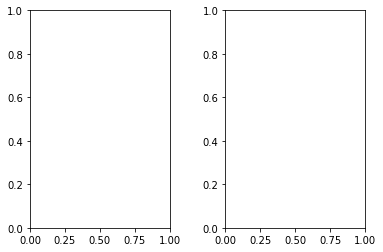

In [4]:
#!/usr/bin/env python
# coding: utf-8

# In[23]:


import os, glob
import copy 
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow import keras
from scipy.ndimage import rotate
from skimage import exposure
from sklearn.metrics import confusion_matrix
from operator import add 
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = np.float
SEG_DTYPE = np.uint8


# In[24]:


if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


# In[25]:


masks_path = os.path.join('train','masks')
training_path = os.path.join('train','patients')


# In[26]:



def imshow(*args,**kwargs):
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

def dice(im1, im2):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())


# In[27]:


class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):

        tumor_volume = None
        
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
       
        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array
        
        image = np.multiply(image,np.clip(liver_mask,0,1))
        
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = cv2.imread(os.path.join(masks_path,'merged_livertumors', id_name+'.jpg'))
        
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        retval, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = mask // 255
        
        mask = mask[:, :, np.newaxis]
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
        for id_name in files_batch:

            _img, _mask = self.__load__(id_name)
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


# In[28]:


image_size =  256
train_path = "train"
batch_size = 16
epochs = 50
## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):

    images.append(file)


## Validation Data Size
val_data_size = len(images)//5 # 20% validation Data
# factor = 0
valid_ids = images[:val_data_size]
#train_ids = images[val_data_size:]
train_ids = images[val_data_size::20]
print(len(train_ids))


# In[29]:



def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Set pixels with hounsfield value great than 1200, to zero.
    2- Clip all hounsfield values to the range [-100, 400]
    3- Apply Histogram Equalization
    """    
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)
    img_slc = normalize_image(img_slc)

    
    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = normalize_image(img_slc)
    return img_slc


# In[30]:


gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape,y.shape)


# In[31]:


'''r = random.randint(0, len(x)-1)
r = 0
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

'''
# In[32]:




#model.save('tumor_model_10epochs.h5')  # creates a HDF5 file 'my_model.h5'
# model.save_weights("tumor_weights_final_50epochs.h5")
#model = keras.models.load_model(os.path.join('models','tumor_model_10epochs.h5'),compile=False)
model = keras.models.load_model('liver_model_final_resunet.h5',compile=False)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
# model.summary()

# del model


# In[38]:


x, y = valid_gen.__getitem__(2)
result = model.predict(x)

# result = result > 0.5

#imshow(x[1])


# In[39]:


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
#ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
#ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")


# In[17]:


# imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")
'''for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4
#     print(id_name)
    for j in range(len(result)):
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
#        ax.imshow(np.reshape(y[j]*255, (image_size, image_size)), cmap="gray")
#         ax.imshow(y[i])
        ax = fig.add_subplot(1, 2, 2)
        #ax.imshow(np.reshape(result[j]*255, (image_size, image_size)), cmap="gray")


# In[40]:
'''

random_batch = random.randint(0, len(valid_ids)//batch_size - 1)
random_sample = random.randint(0, batch_size-1)
random_batch = 4
random_sample = 2
print(random_batch)
print(random_sample)
#x, y = valid_gen.__getitem__(random_batch)
x, y = valid_gen.__getitem__(2)
#print(x[2].shape, y[2].shape)
#img = cv2.hconcat(y[1]*255, x[1])
imgout = y[2]*255 
imgin = x[2]*255 
cv2.imwrite('static/pics/test_in.jpg',imgin.astype(np.uint8))
cv2.imwrite('static/pics/test_out.jpg',imgout.astype(np.uint8))
print(imgout.shape)
#cv2.imshow('img',x[2])
#cv2.waitKey(0)
#cv2.imshow('img',y[2])
#cv2.waitKey(0)
#exit(0)
result =  model.predict(x)
result = result > 0
'''
fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(1,1,1)
#ax2.imshow(x[random_sample])

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
#ax.imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
#         ax.imshow(y[i])
ax = fig.add_subplot(1, 2, 2)
#ax.imshow(np.reshape(result[random_sample]*255, (image_size, image_size)), cmap="gray")

# imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
cm_2d = confusion_matrix(y[random_sample].flatten(), result[random_sample].flatten())
cm = cm_2d.ravel()

# (tn, fp, fn, tp)
print(cm_2d)
print(cm)


# In[41]:
print("Pixel Accuracy " + str(((cm[3]+cm[0])/(cm[3]+cm[0]+cm[1]+cm[2])*100))+'%' )
print("True Positive Accuracy " + str(((cm[3])/(cm[3]+cm[2])*100))+'%' )
print("Dice Coefficient " + str(dice(y[random_sample], result[random_sample])))
'''

print('cm....')

# In[42]:


'''ax= plt.subplot()
cm_2d = cm_2d.astype('float') / cm_2d.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_2d, annot=True, ax = ax); #annot=True to annotate cells

#print(count_cms)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Tumor', 'Tumor']); ax.yaxis.set_ticklabels(['No Tumor', 'Tumor']);

'''
# In[43]:

from flask import Flask, render_template
import os

app = Flask(__name__)

picFolder = os.path.join('static', 'pics')
print(picFolder)
app.config['UPLOAD_FOLDER'] = picFolder


@app.route("/")
def index():
    pic1 = os.path.join(app.config['UPLOAD_FOLDER'], 'test_in.jpg')
    return render_template("index.html", user_image=pic1)


@app.route("/index")
def index1():
    
    return "hello"
@app.route('/results')
def result():
    pic1 = os.path.join(app.config['UPLOAD_FOLDER'], 'test_out.jpg')
    return render_template("results.html", user_image=pic1)

app.run(host="192.168.56.1",port=5000)


In [ ]:
import os, glob
import sys
import copy 
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow import keras
from scipy.ndimage import rotate
from skimage import exposure
from sklearn.metrics import confusion_matrix
from operator import add 
plt.set_cmap('gray')
%matplotlib inline
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = np.float
SEG_DTYPE = np.uint8


In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

In [3]:
masks_path = os.path.join('train','masks')
training_path = os.path.join('train','patients')

In [4]:

def imshow(*args,**kwargs):
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

def dice(im1, im2):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [5]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):

        tumor_volume = None
        
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
       
        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array
        
        image = np.multiply(image,np.clip(liver_mask,0,1))
        
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = cv2.imread(os.path.join(masks_path,'merged_livertumors', id_name+'.jpg'))
        
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        retval, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = mask // 255
        
        mask = mask[:, :, np.newaxis]
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
        for id_name in files_batch:

            _img, _mask = self.__load__(id_name)
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [6]:
image_size =  256
train_path = "train"
batch_size = 16
epochs = 10
## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):

    images.append(file)


## Validation Data Size
val_data_size = len(images)//5 # 20% validation Data
# factor = 0
valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]
print(len(train_ids))

18617


In [7]:

def step1_preprocess_img_slice(img_slc):
      
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)
    img_slc = normalize_image(img_slc)

    
    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = normalize_image(img_slc)
    return img_slc


In [8]:
gen = DataGen(train_ids, train_path, batch_size= batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape,y.shape)

(16, 256, 256, 3) (16, 256, 256, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


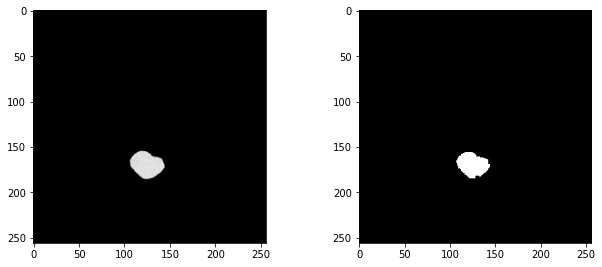

In [9]:
r = random.randint(0, len(x)-1)
r = 0
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [10]:

def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [11]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [12]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [13]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=["acc", dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 128)  512        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 128)  8320        ['add_2[0][0]']                  
                                                                                                  
 activation_6 (Activation)      (None, 32, 32, 128)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 128)  512        ['conv2d_11[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 batch_normalization_19 (BatchN  (None, 64, 64, 320)  1280       ['concatenate_1[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 320)  0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 64, 128)  368768      ['activation_13[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 64, 64, 128)  512        ['conv2d_20[0][0]']              
 ormalization)                                                                                    
          

 conv2d_27 (Conv2D)             (None, 256, 256, 32  9248        ['activation_18[0][0]']          
                                )                                                                 
                                                                                                  
 add_8 (Add)                    (None, 256, 256, 32  0           ['batch_normalization_27[0][0]', 
                                )                                 'conv2d_27[0][0]']              
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 1)  33          ['add_8[0][0]']                  
                                                                                                  
Total params: 4,723,057
Trainable params: 4,715,761
Non-trainable params: 7,296
__________________________________________________________________________________________________


In [14]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
# test_gen  = DataGenTest(train_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=5)

C:\Users\Kedaresh\AppData\Local\Temp\ipykernel_10176\2022793096.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


Epoch 1/5
1163/1163 [==============================] - 641s 538ms/step - loss: 0.6242 - acc: 0.9844 - dice_coef: 0.3857 - val_loss: 0.9943 - val_acc: 0.9285 - val_dice_coef: 0.0057
Epoch 2/5
1163/1163 [==============================] - 562s 484ms/step - loss: 0.7055 - acc: 0.9929 - dice_coef: 0.2801 - val_loss: 0.9698 - val_acc: 0.9924 - val_dice_coef: 0.0302
Epoch 3/5
1163/1163 [==============================] - 352s 303ms/step - loss: 0.8574 - acc: 0.9925 - dice_coef: 0.1426 - val_loss: 0.9698 - val_acc: 0.9924 - val_dice_coef: 0.0302
Epoch 4/5
1163/1163 [==============================] - 306s 263ms/step - loss: 0.8585 - acc: 0.9927 - dice_coef: 0.1415 - val_loss: 0.9698 - val_acc: 0.9924 - val_dice_coef: 0.0302
Epoch 5/5
1163/1163 [==============================] - 309s 266ms/step - loss: 0.8517 - acc: 0.9923 - dice_coef: 0.1483 - val_loss: 0.9698 - val_acc: 0.9924 - val_dice_coef: 0.0302


In [5]:
model.save('models/tumor_model_5.h5')  # creates a HDF5 file 'my_model.h5'
# model.save_weights("tumor_weights_final_50epochs.h5")
model = keras.models.load_model(os.path.join('models','tumor_model.h5'),compile=False)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
# model.summary()

# del model

In [1]:
x, y = valid_gen.__getitem__(2)
result = model.predict(x)

# result = result > 0.5

imshow(x[1])


NameError: name 'valid_gen' is not defined

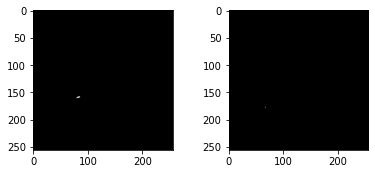

In [17]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

C:\Users\Kedaresh\AppData\Local\Temp\ipykernel_10176\3367370239.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,20))


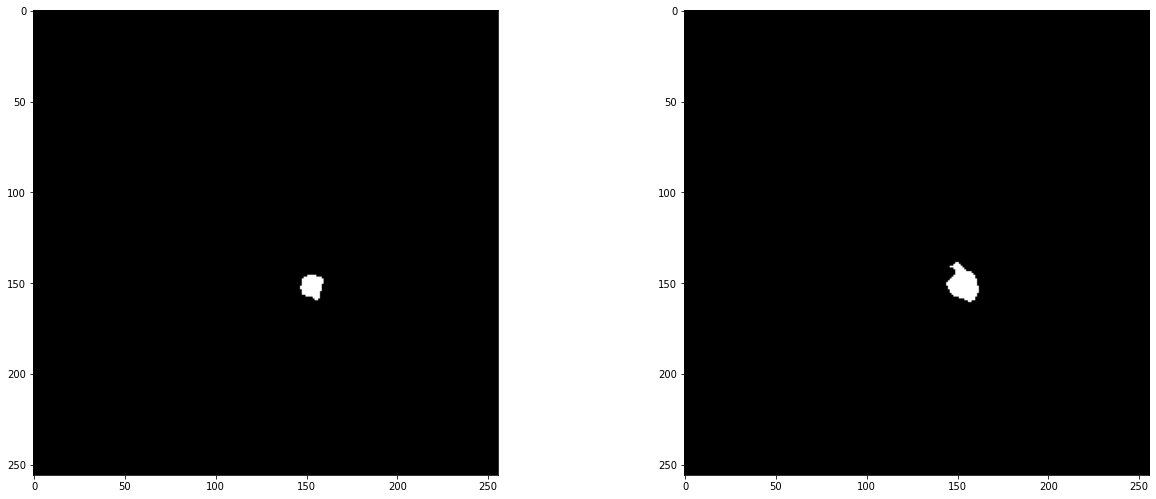

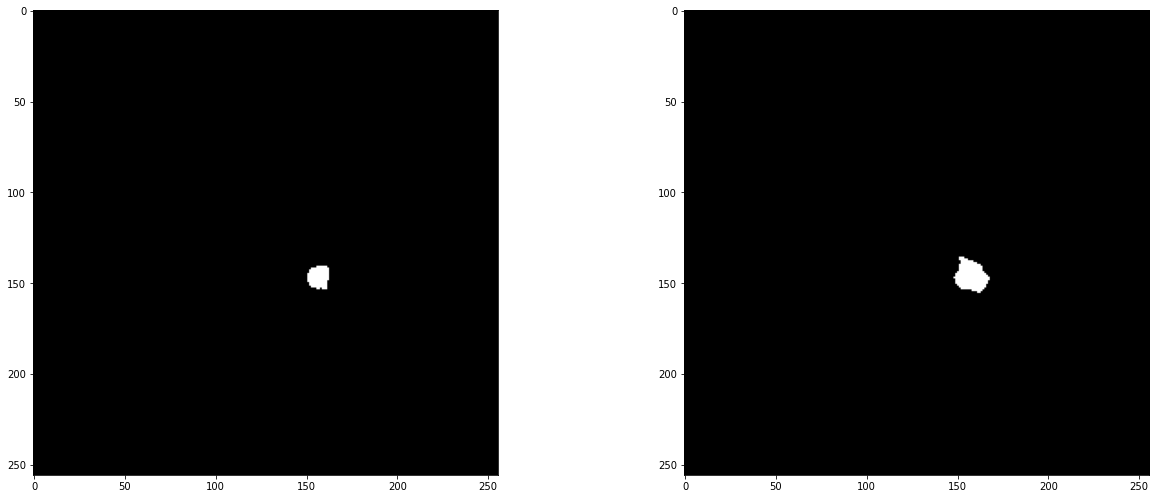

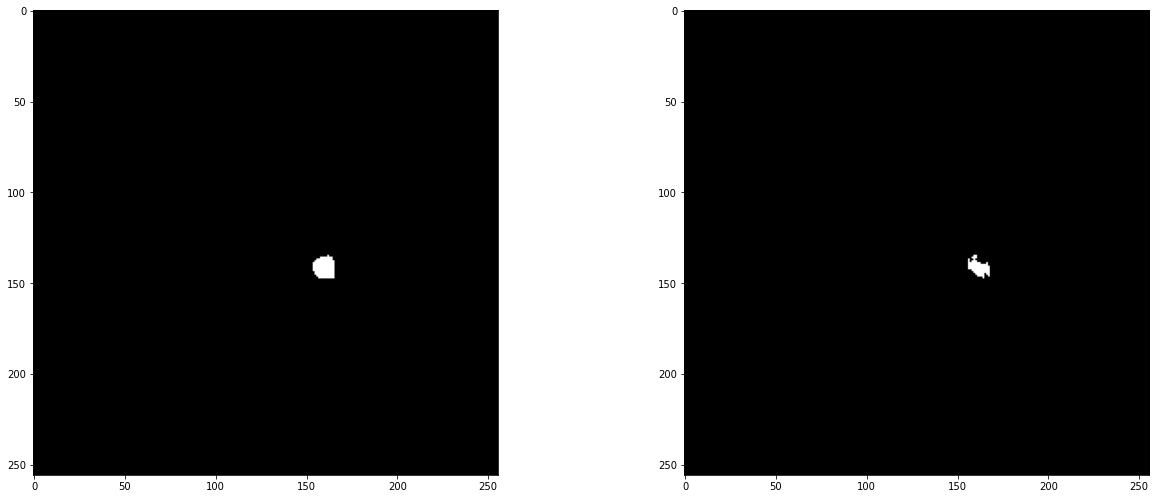

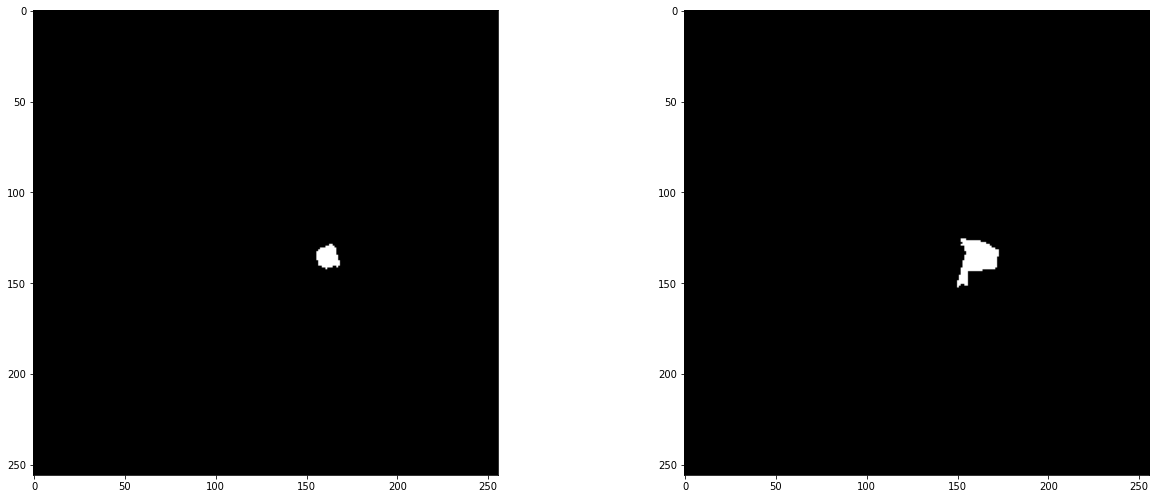

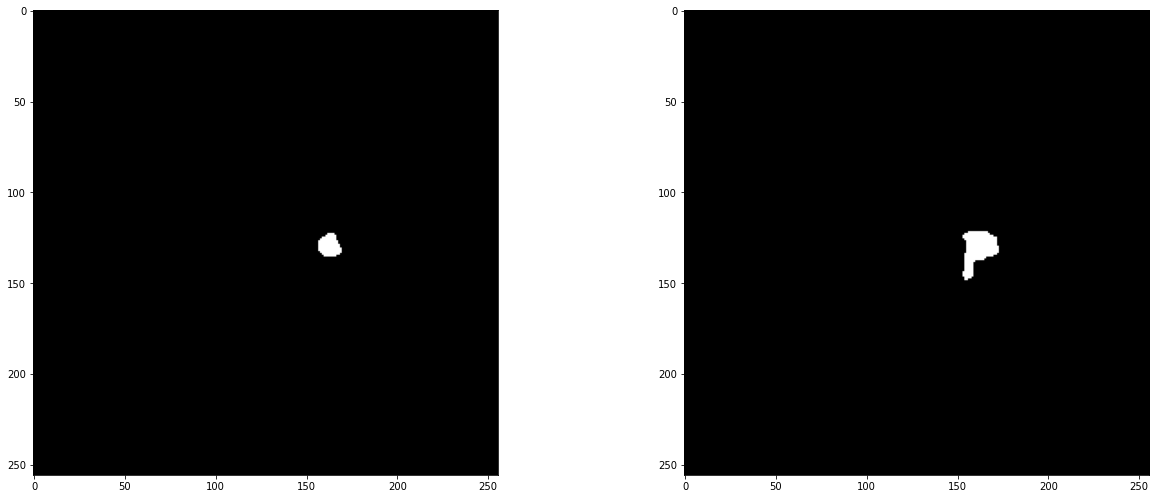

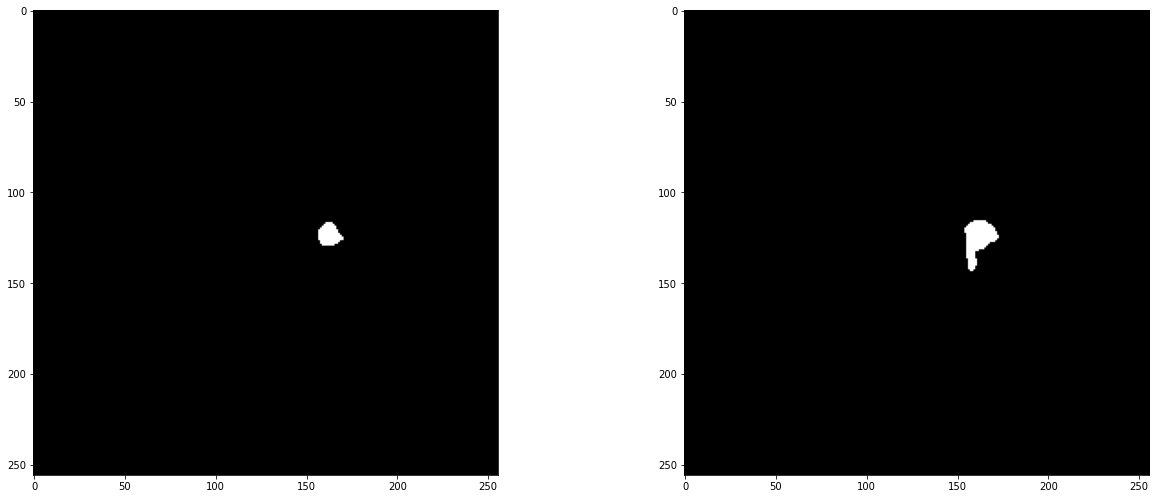

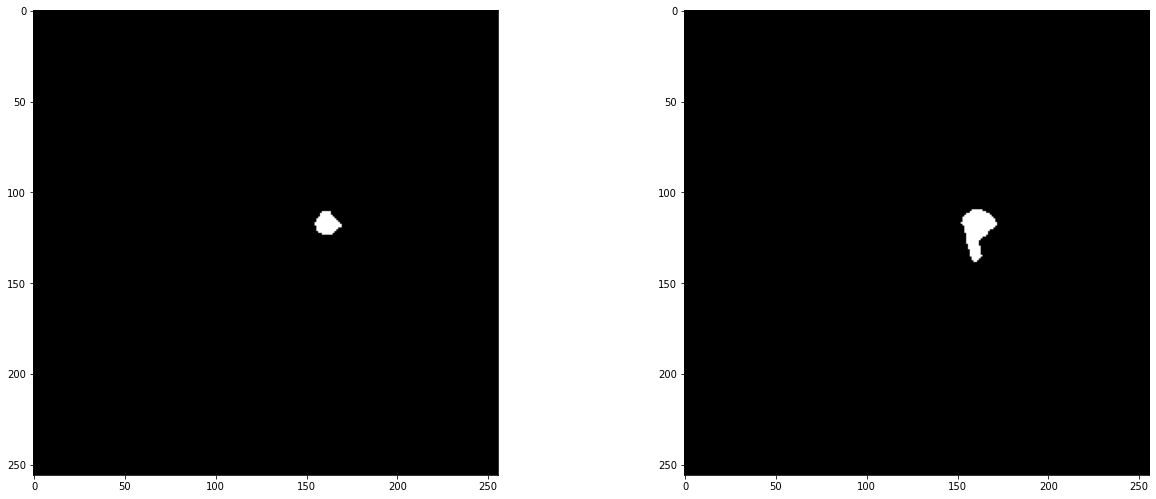

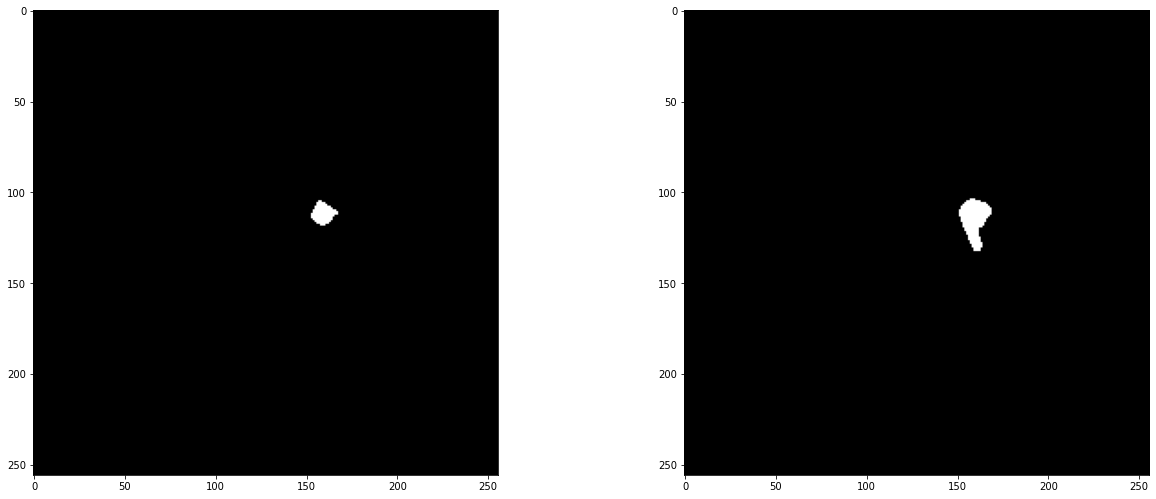

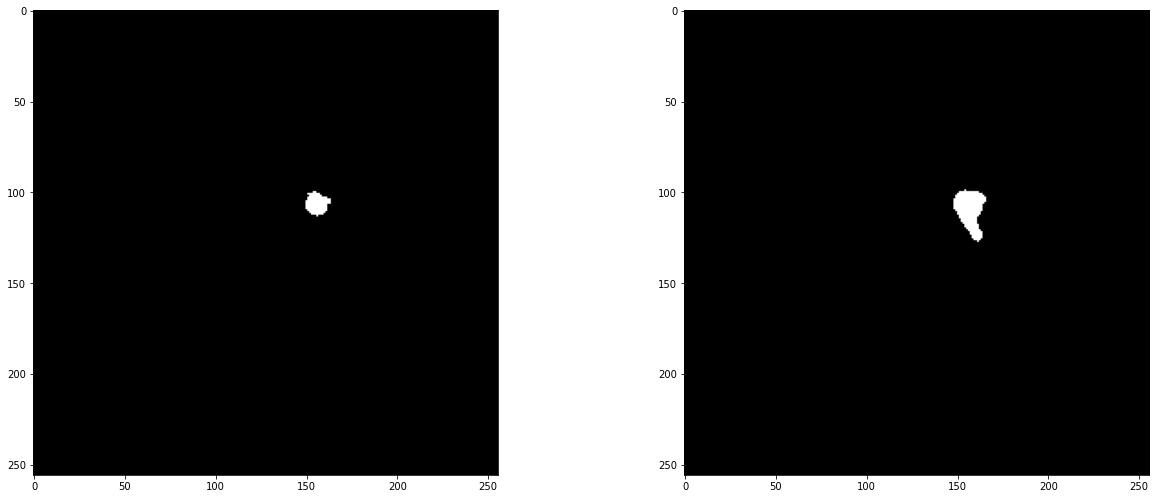

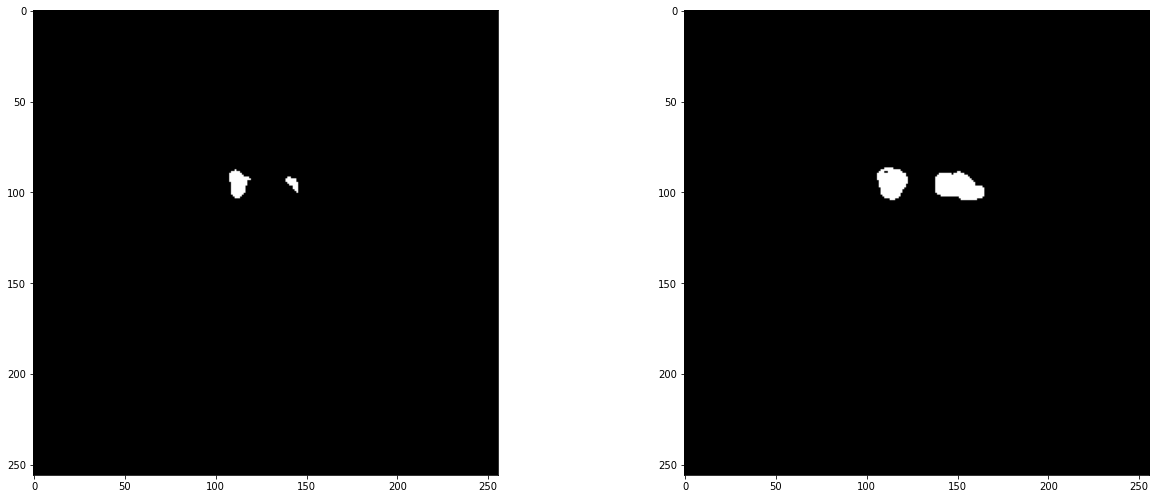

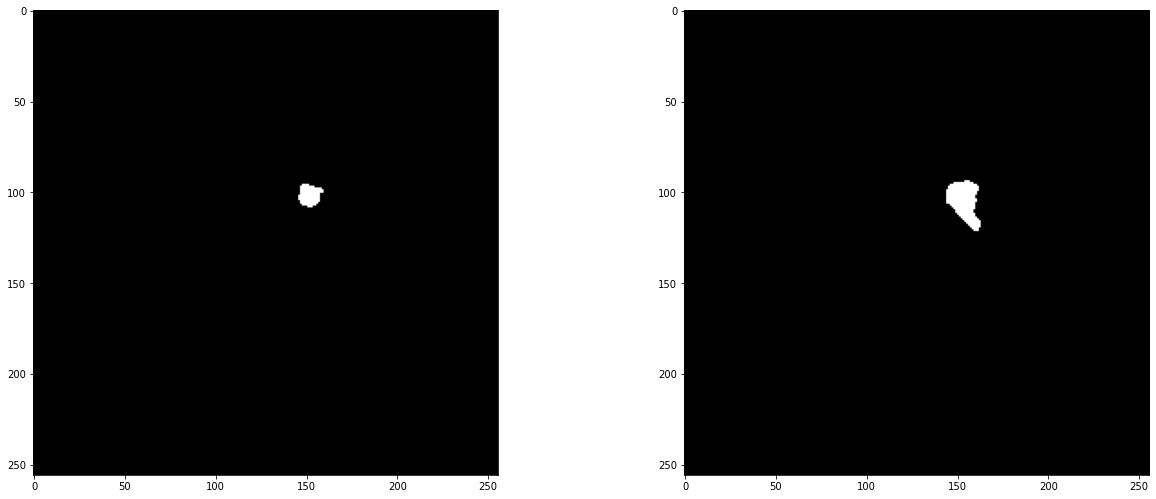

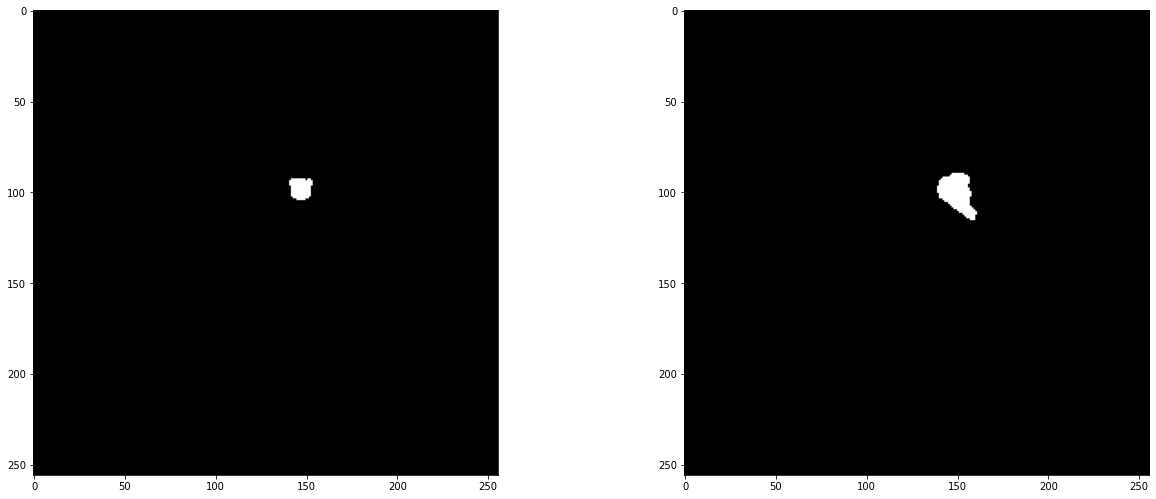

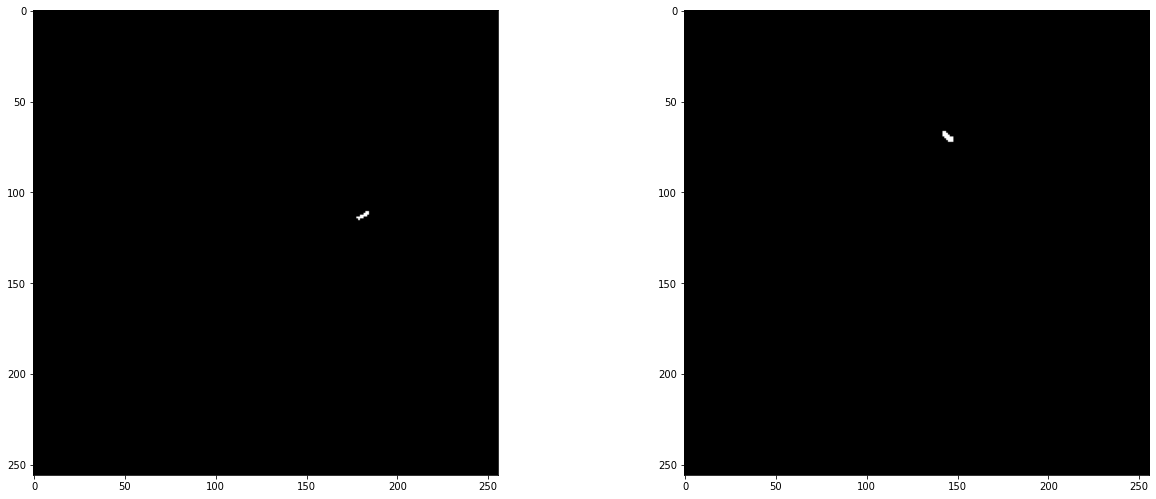

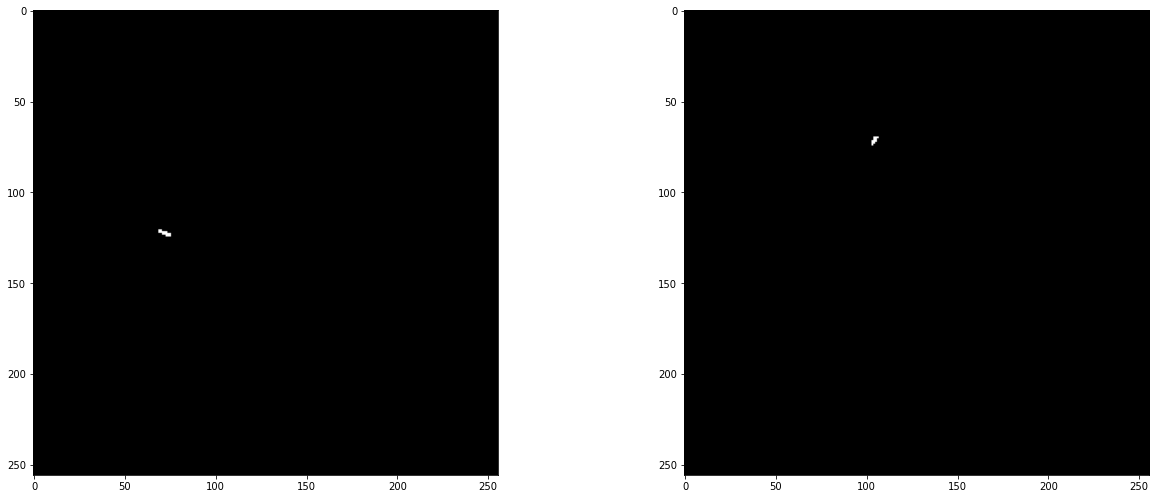

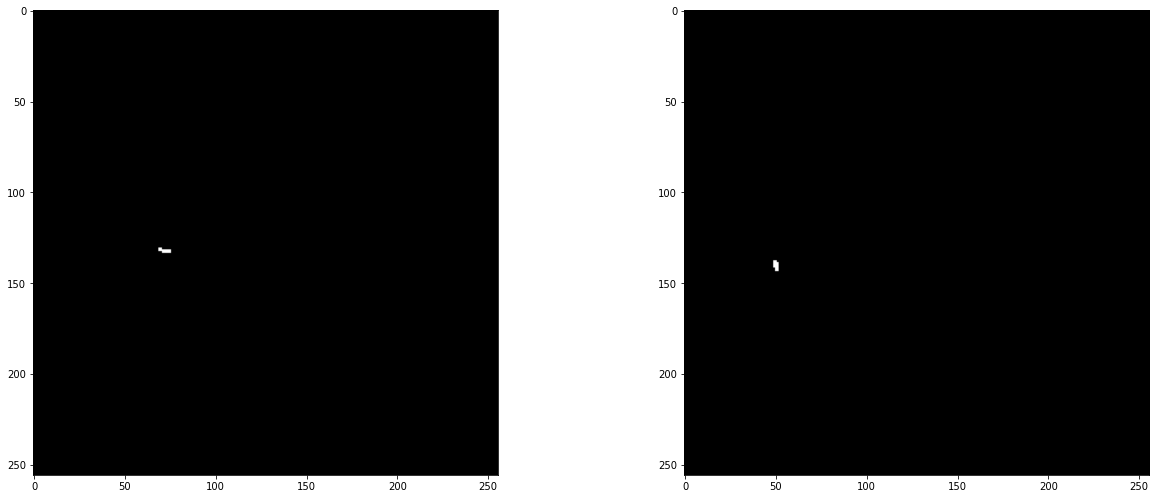

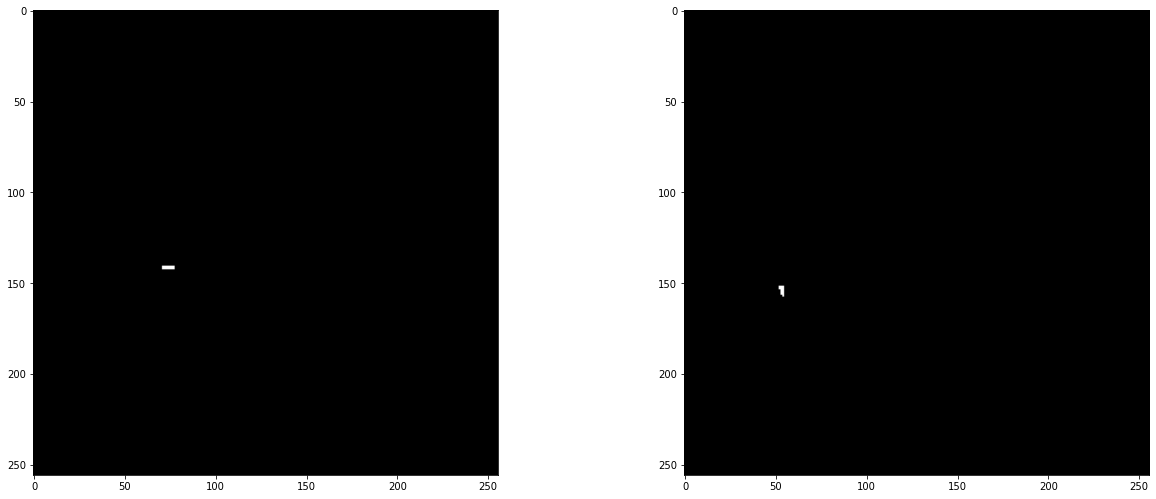

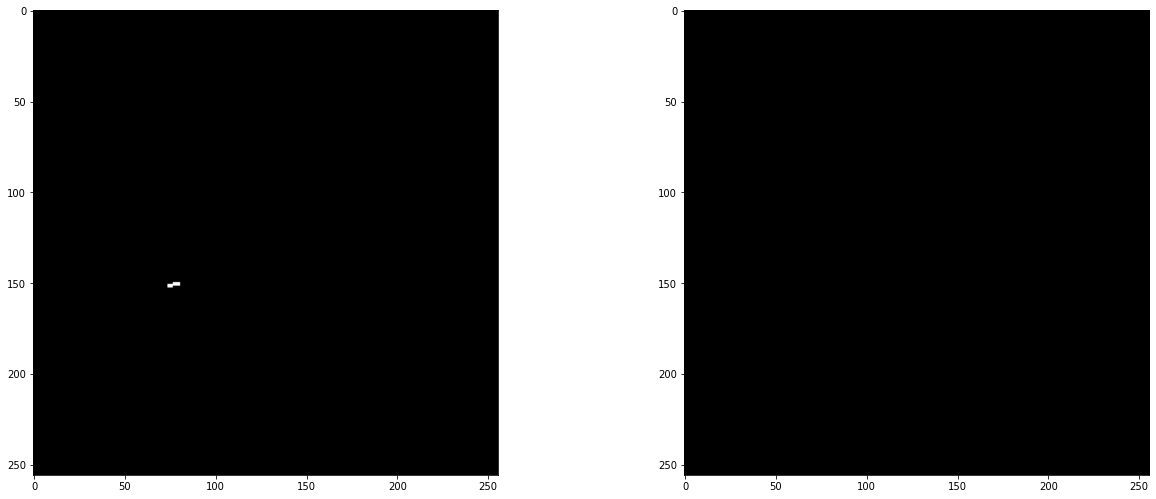

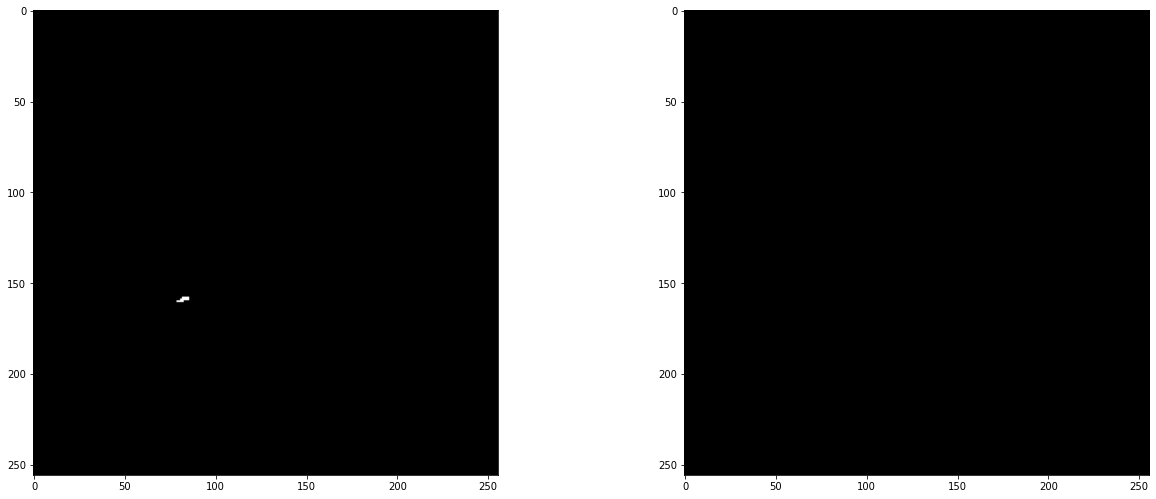

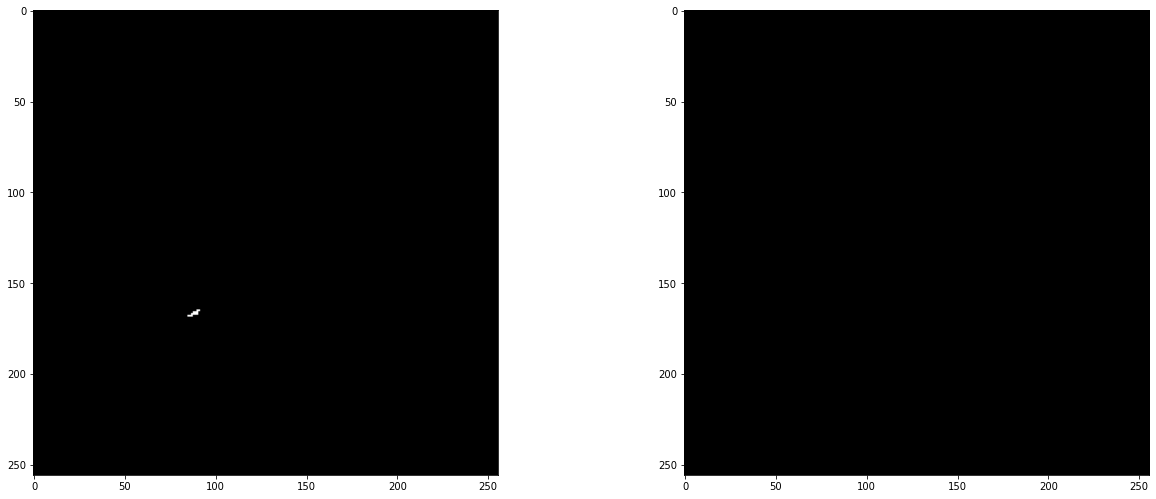

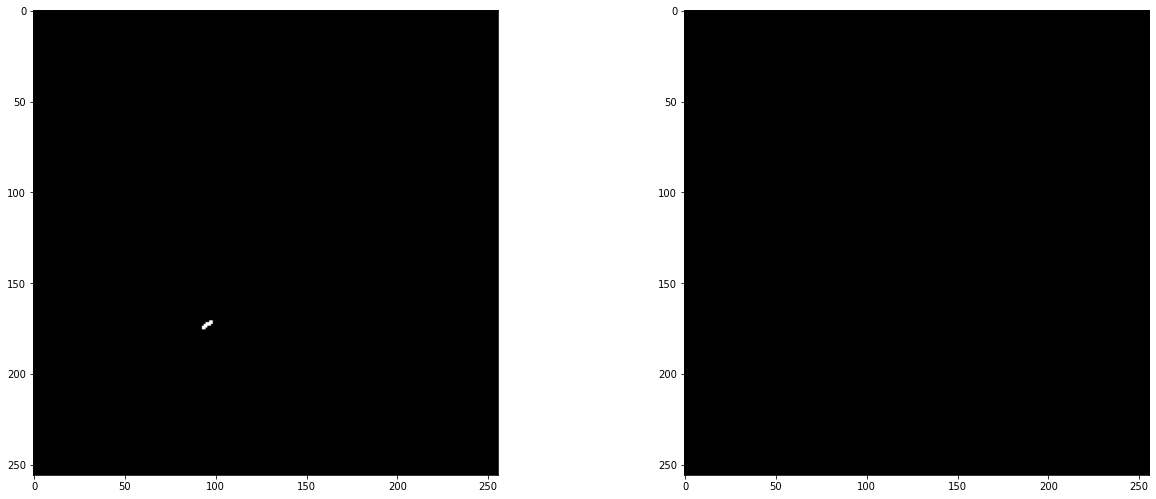

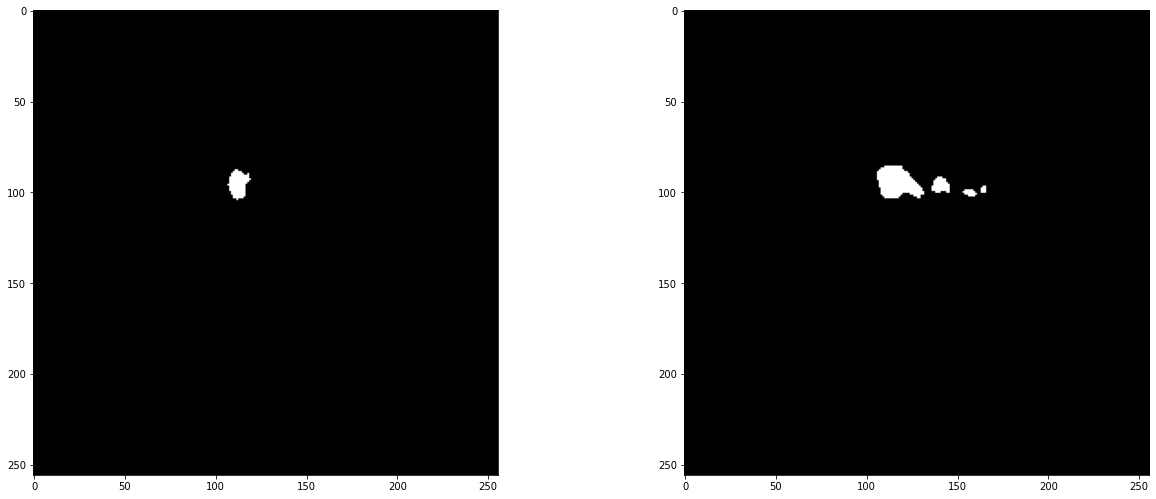

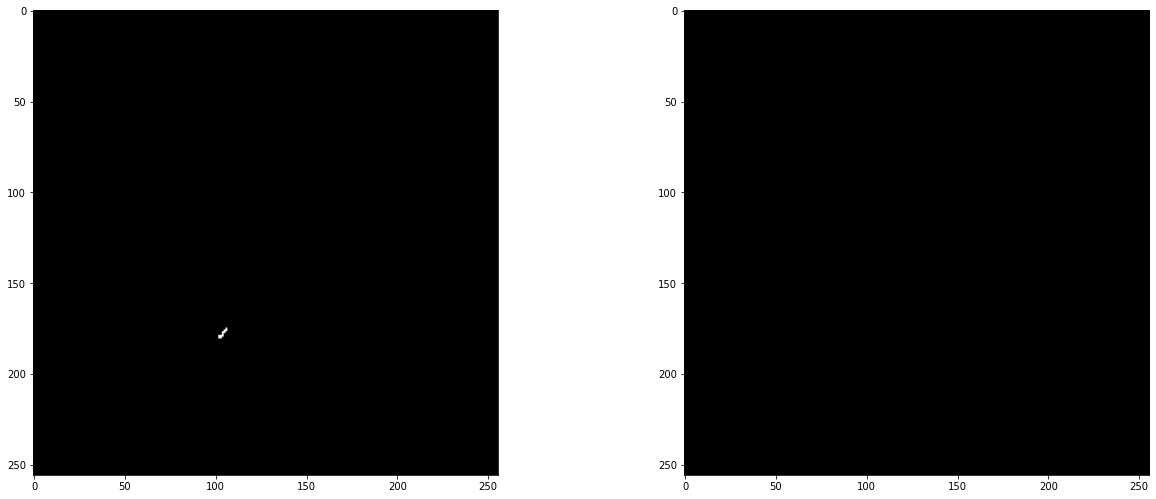

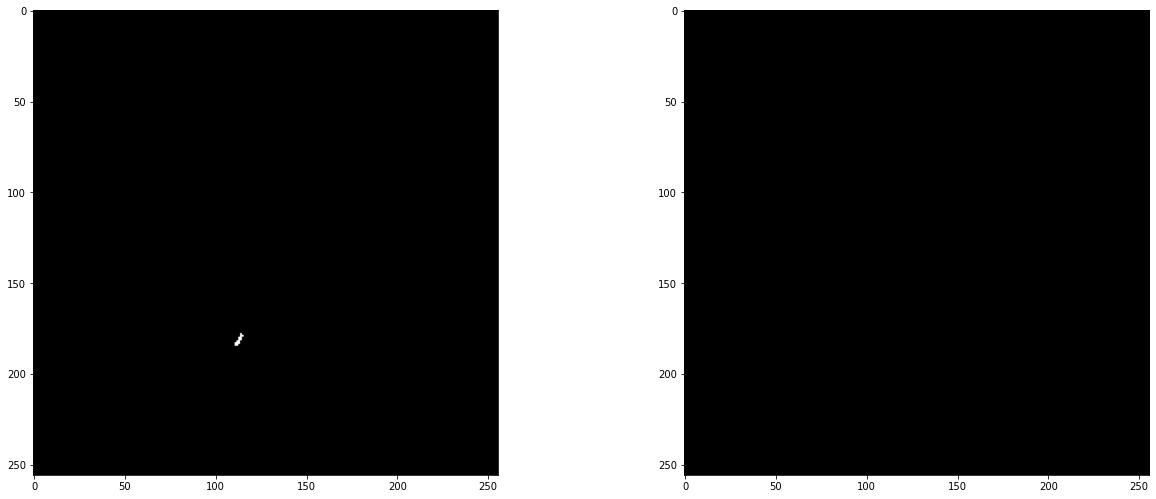

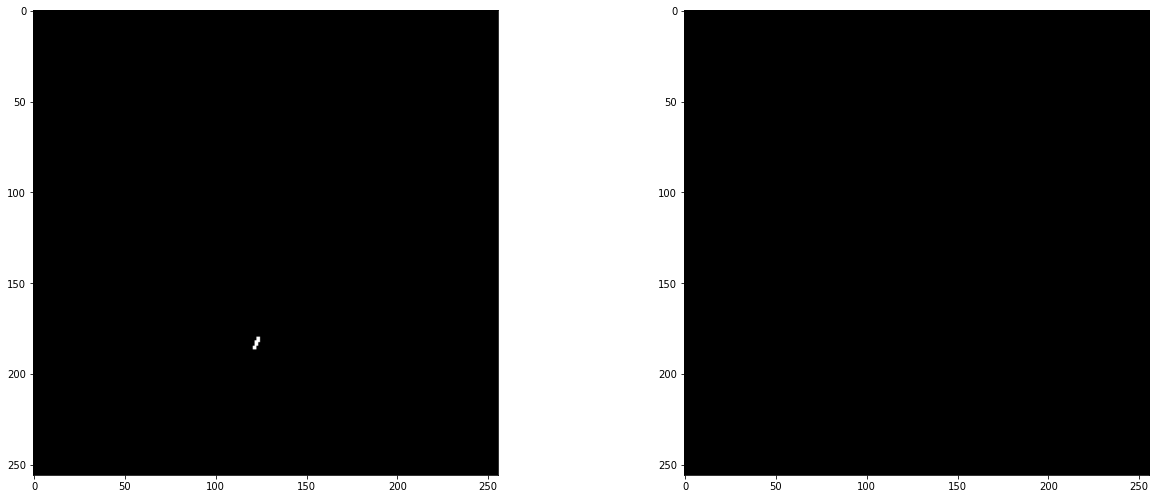

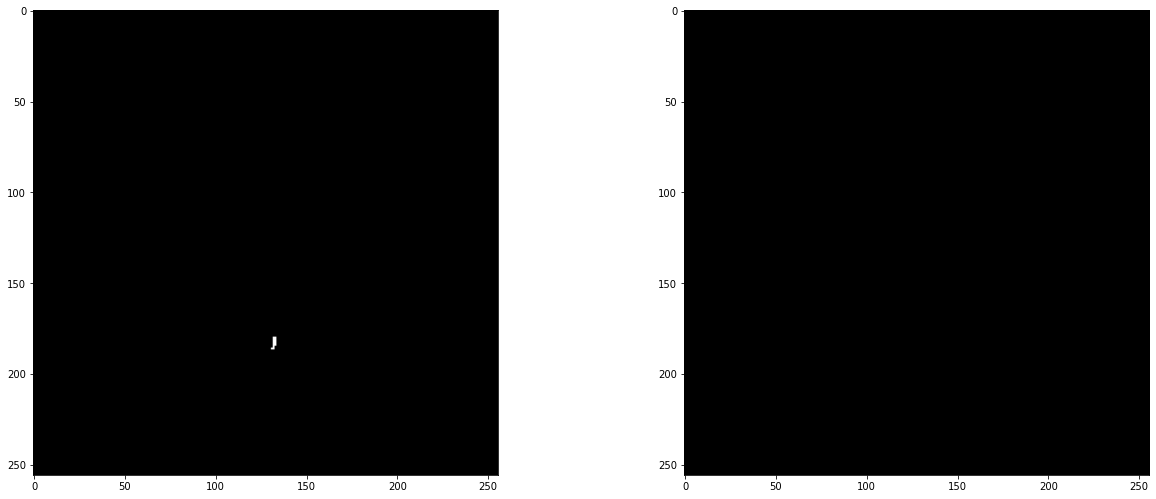

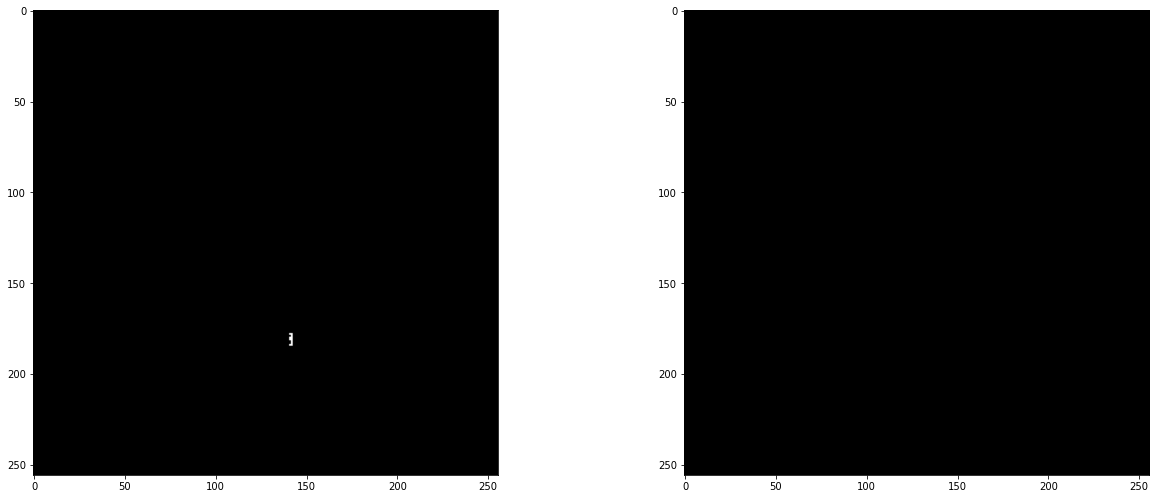

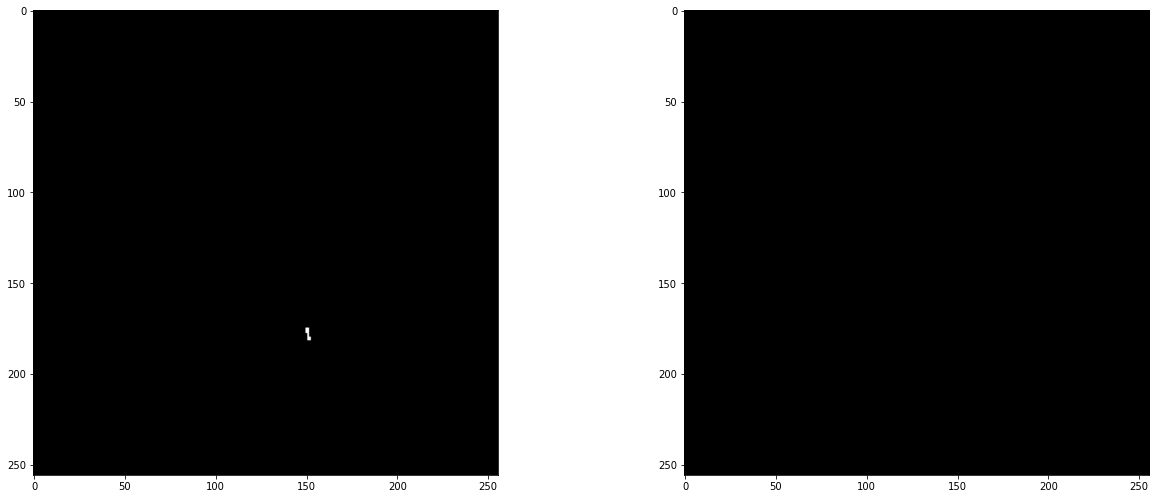

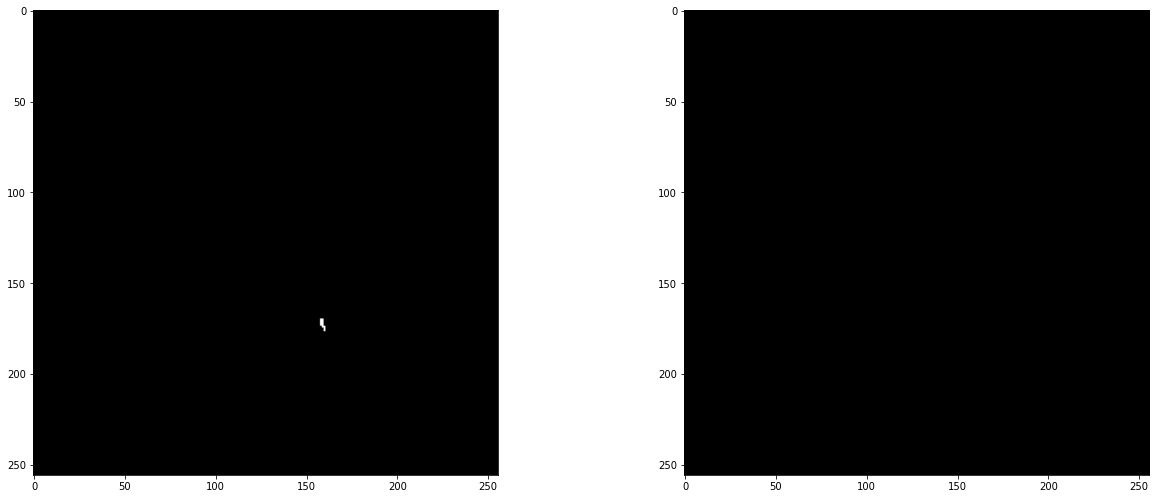

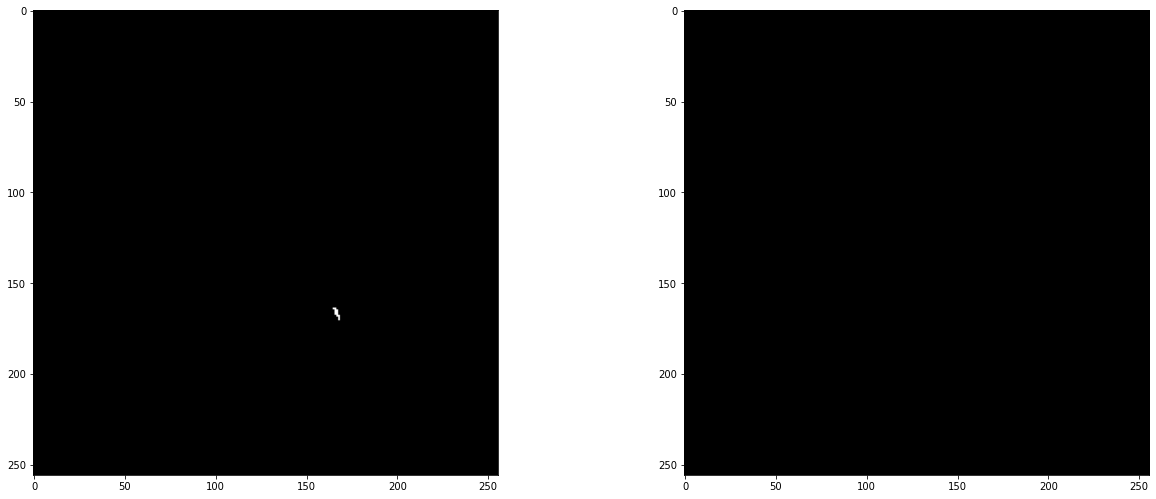

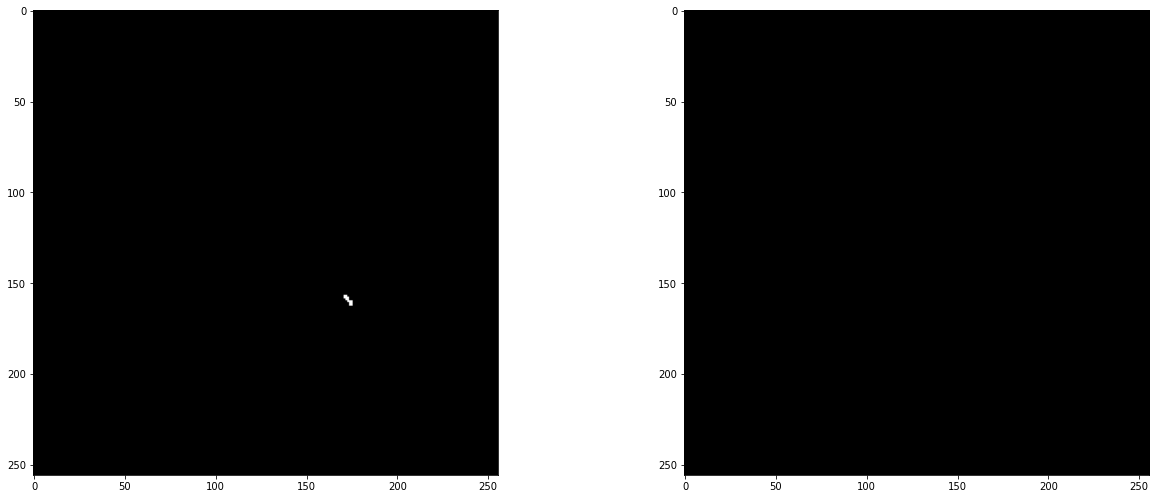

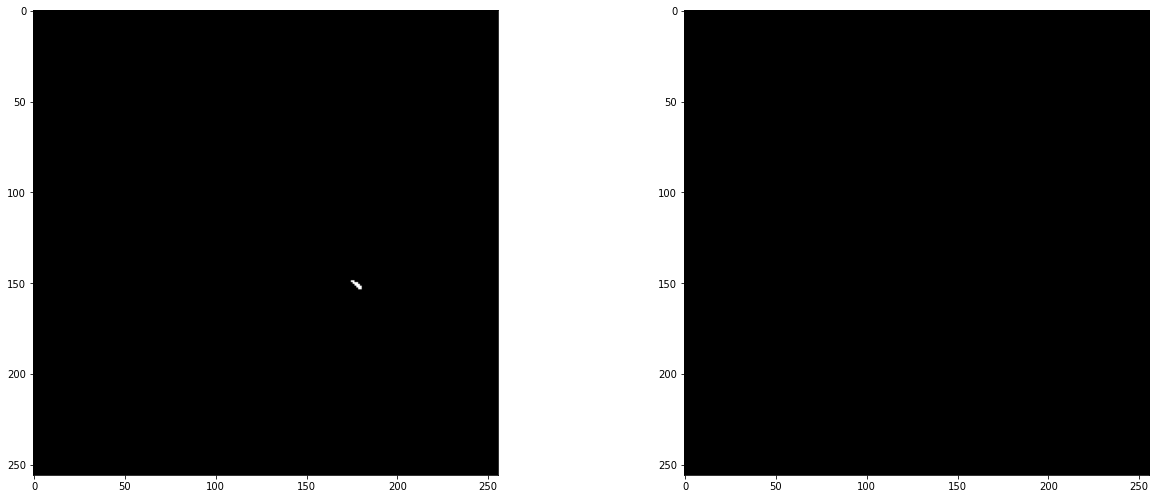

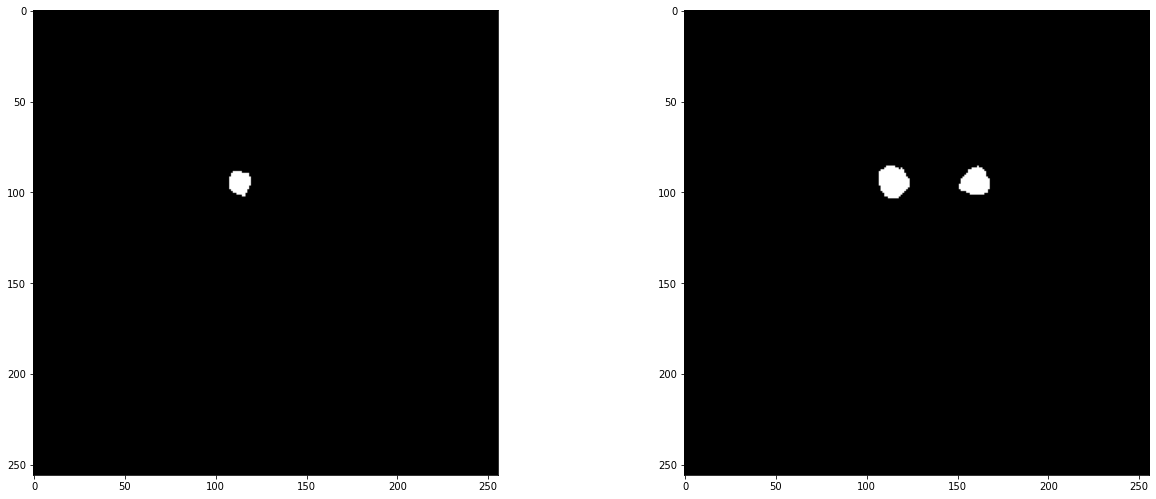

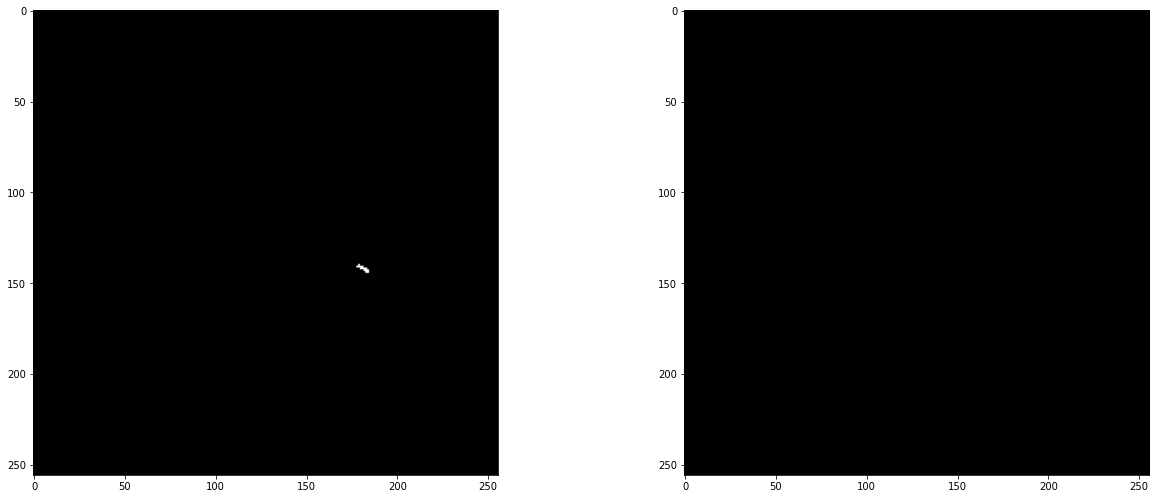

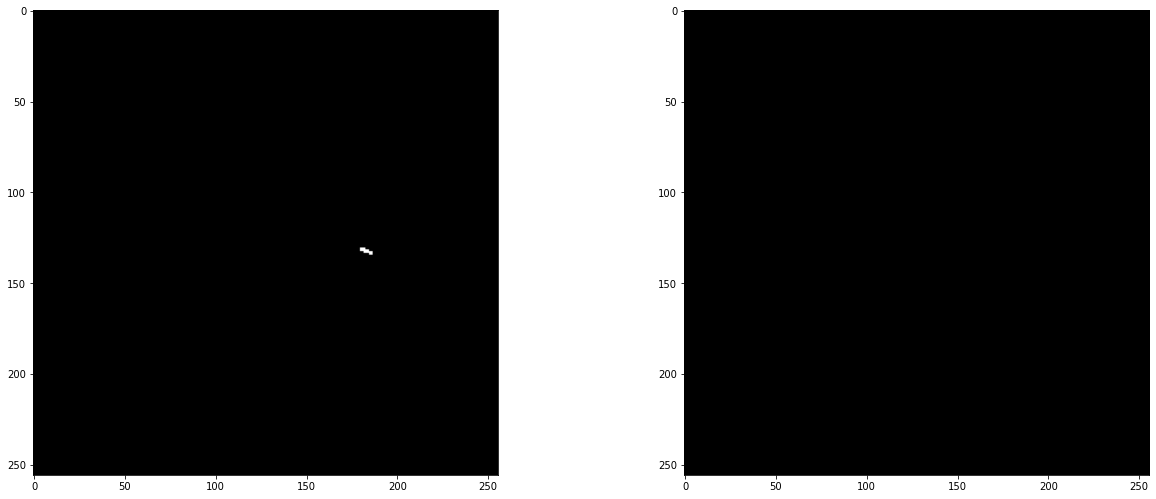

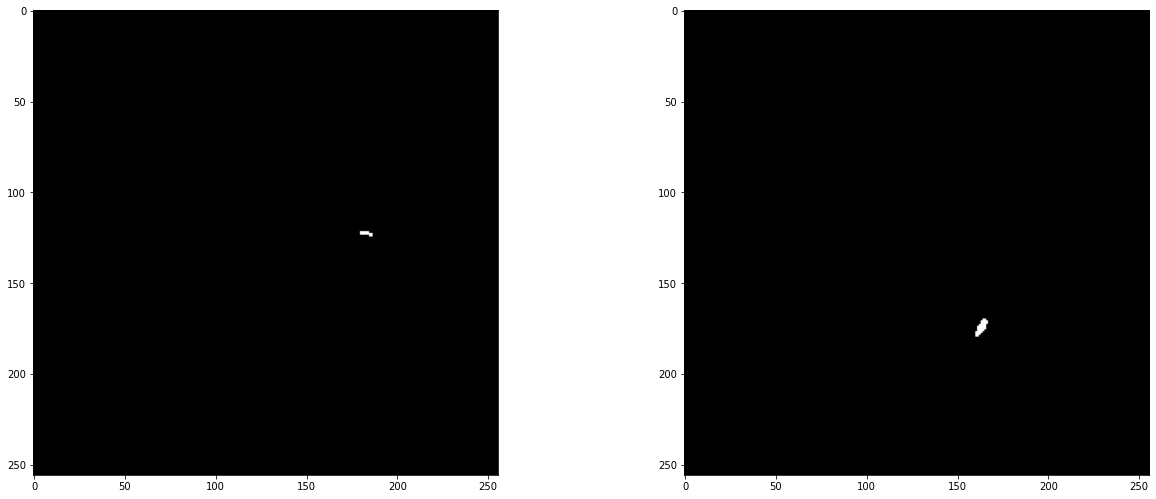

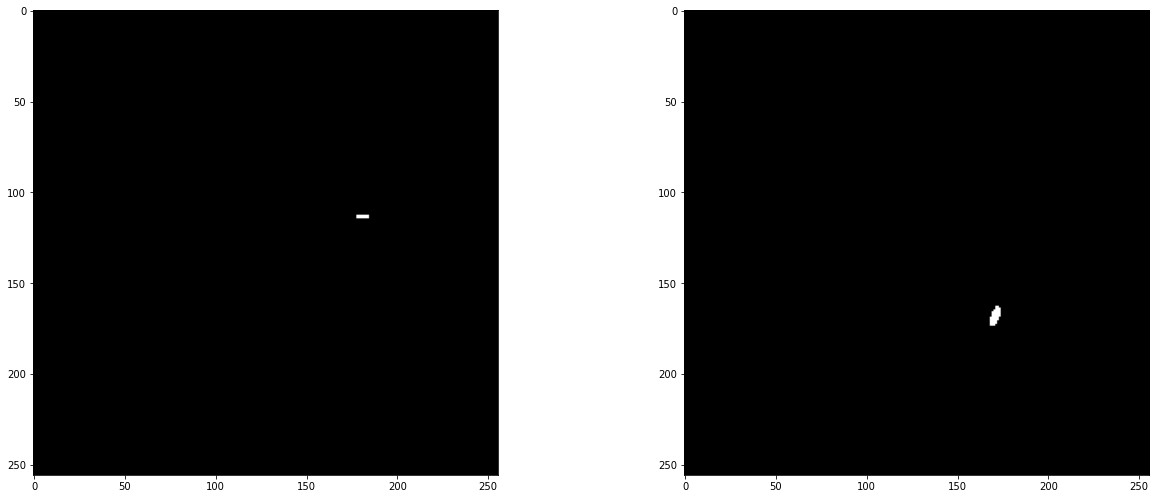

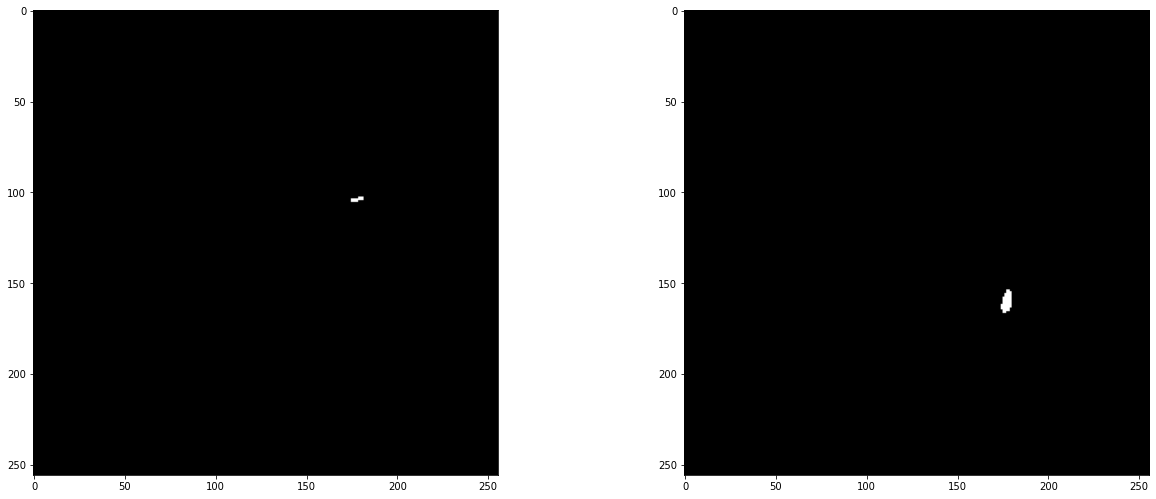

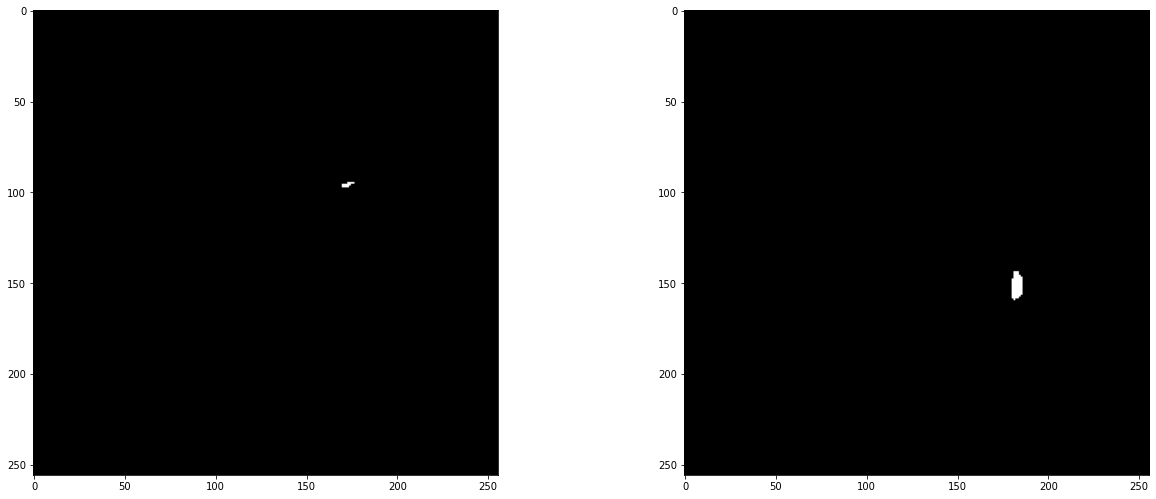

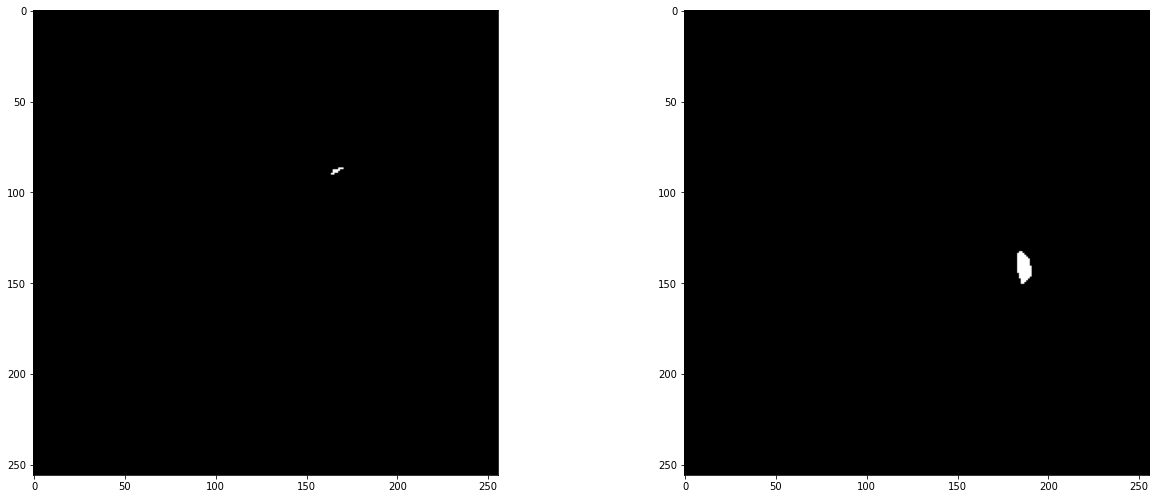

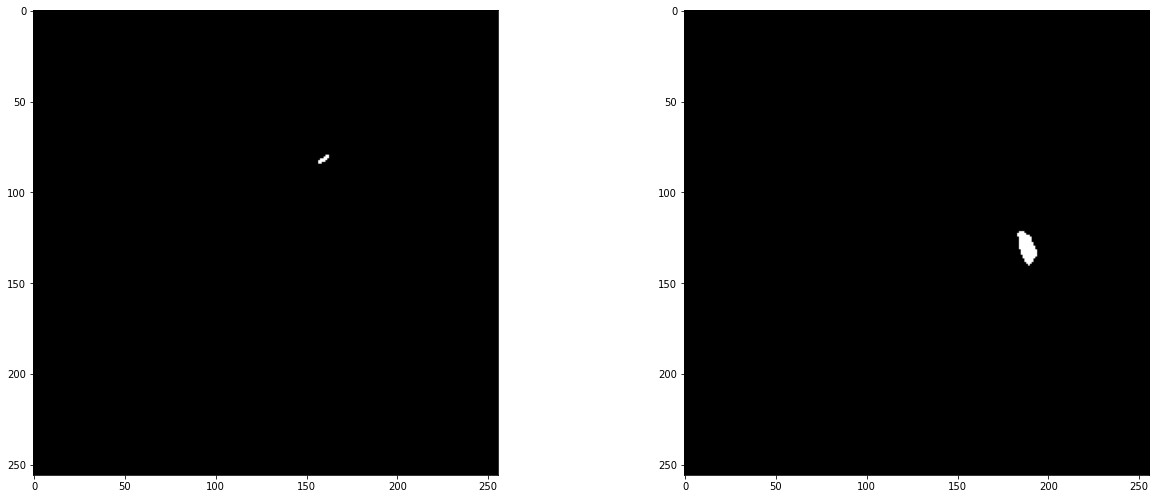

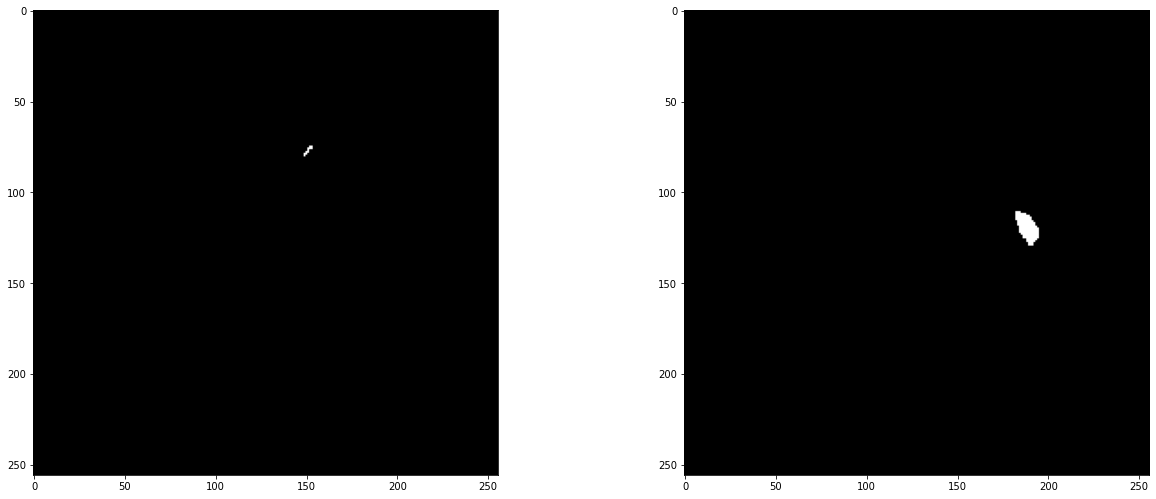

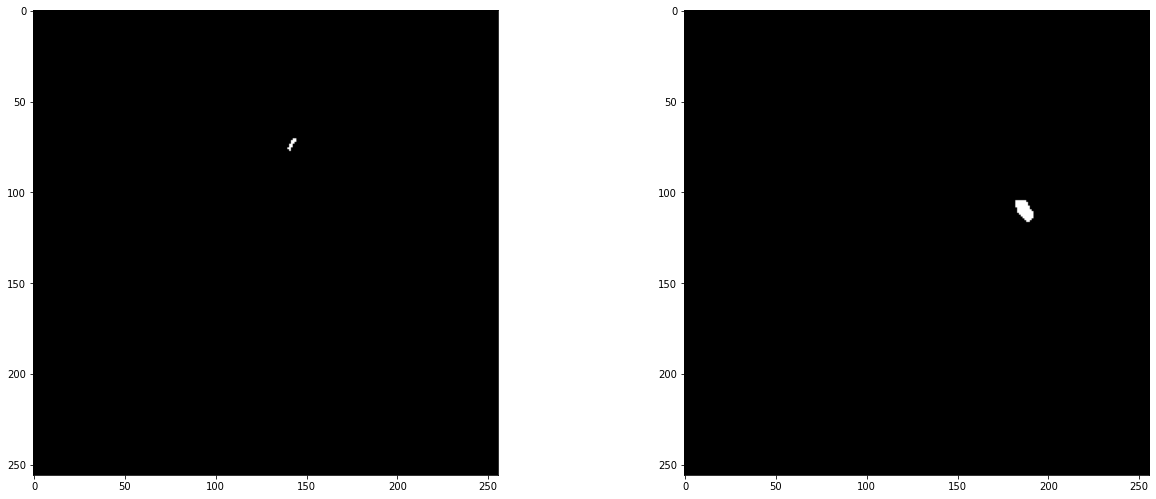

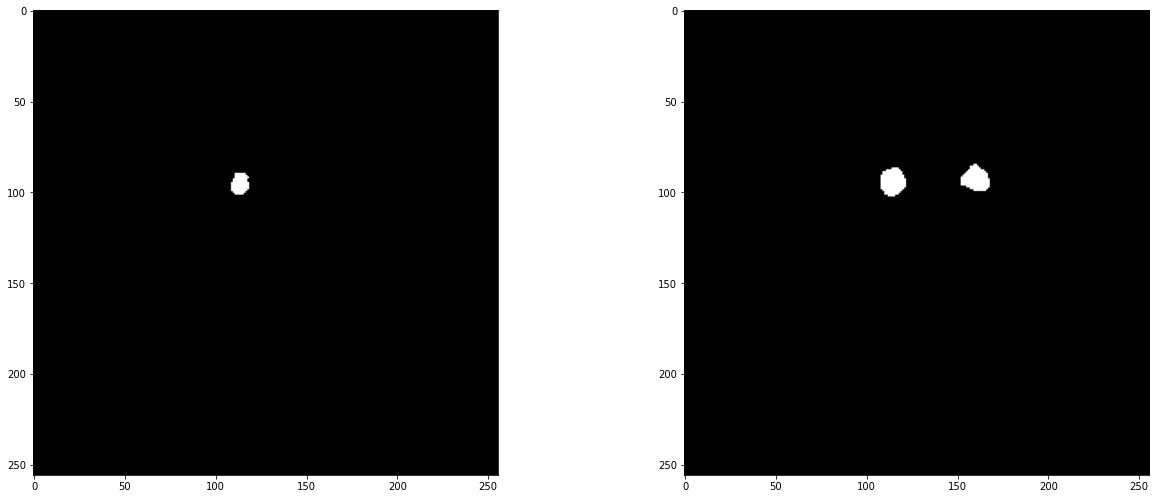

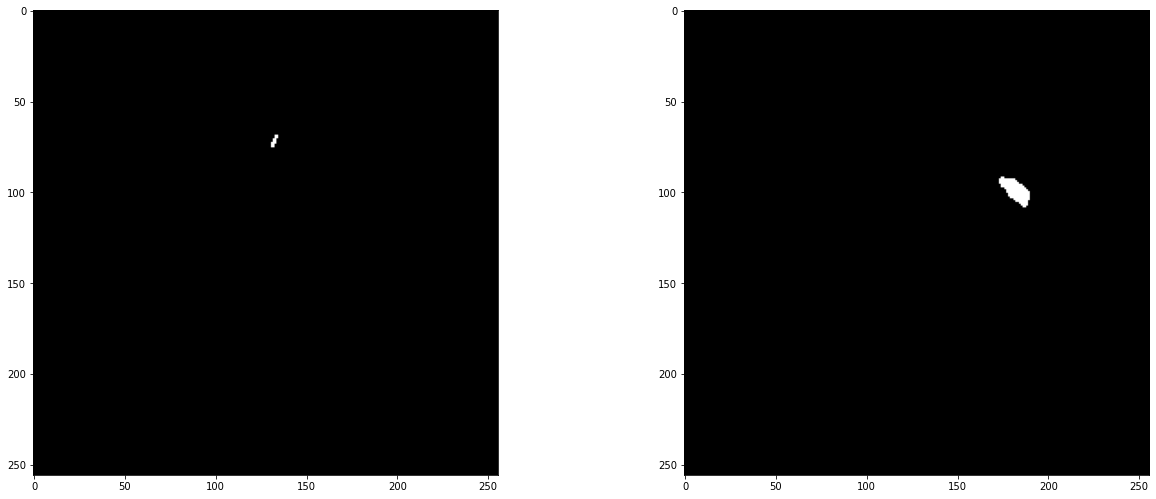

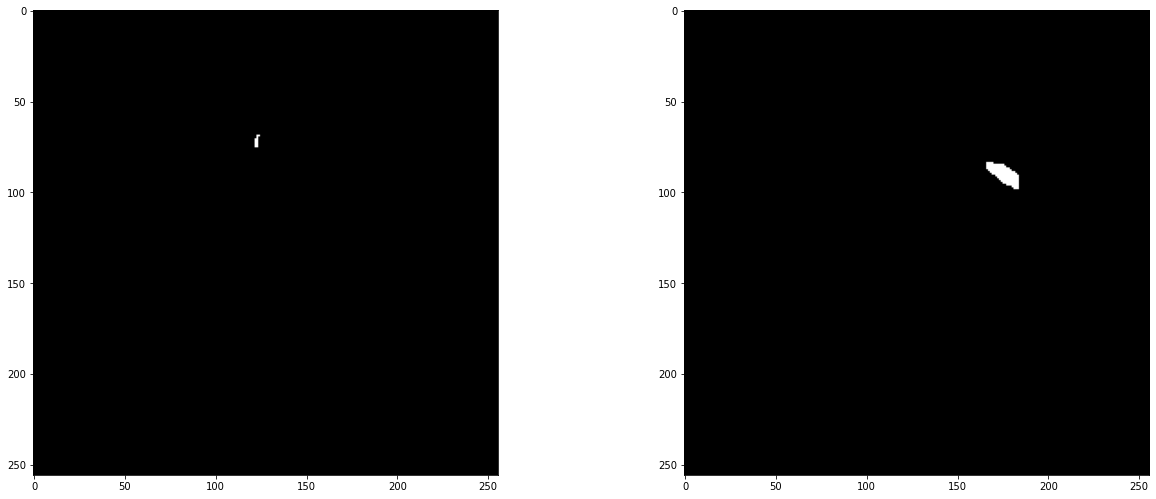

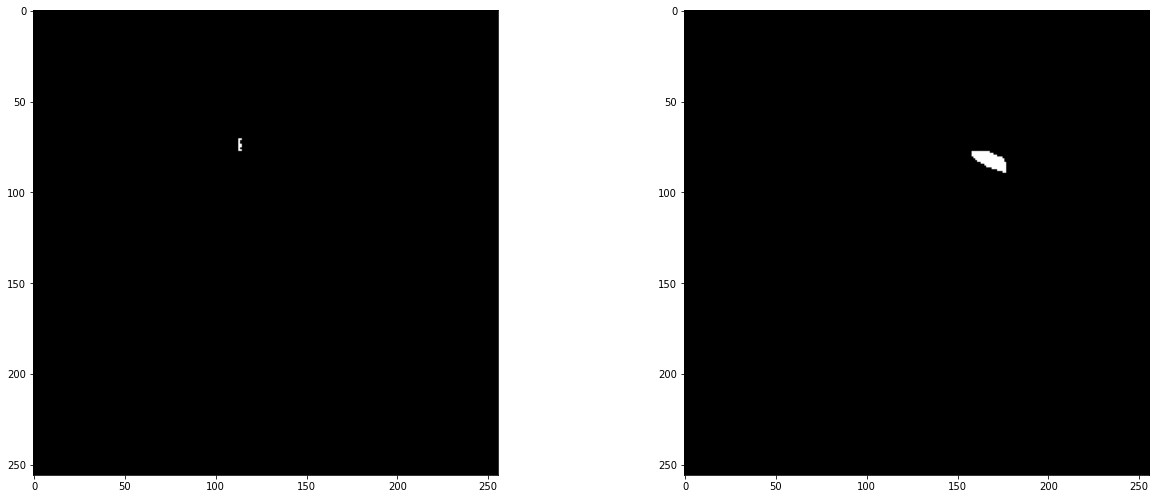

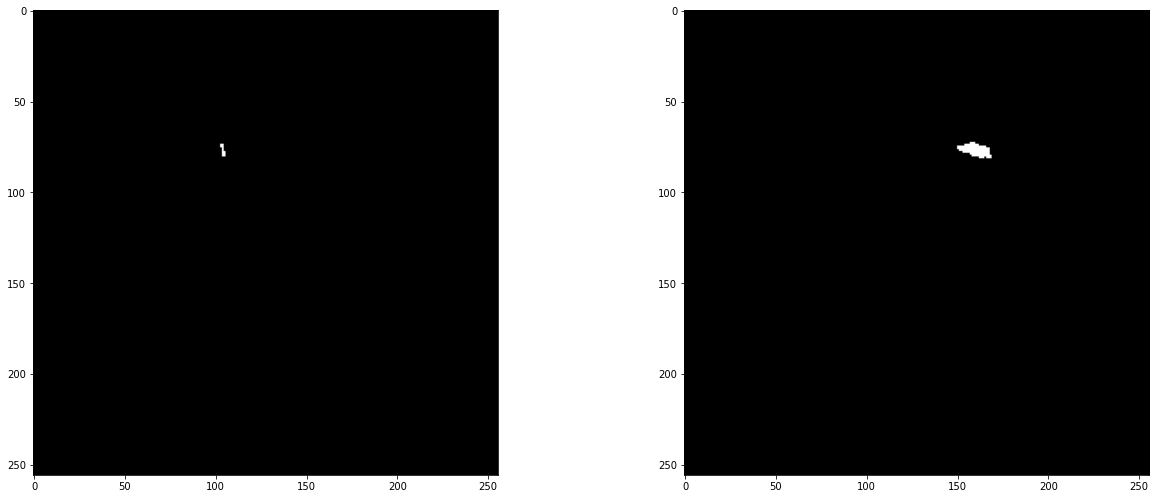

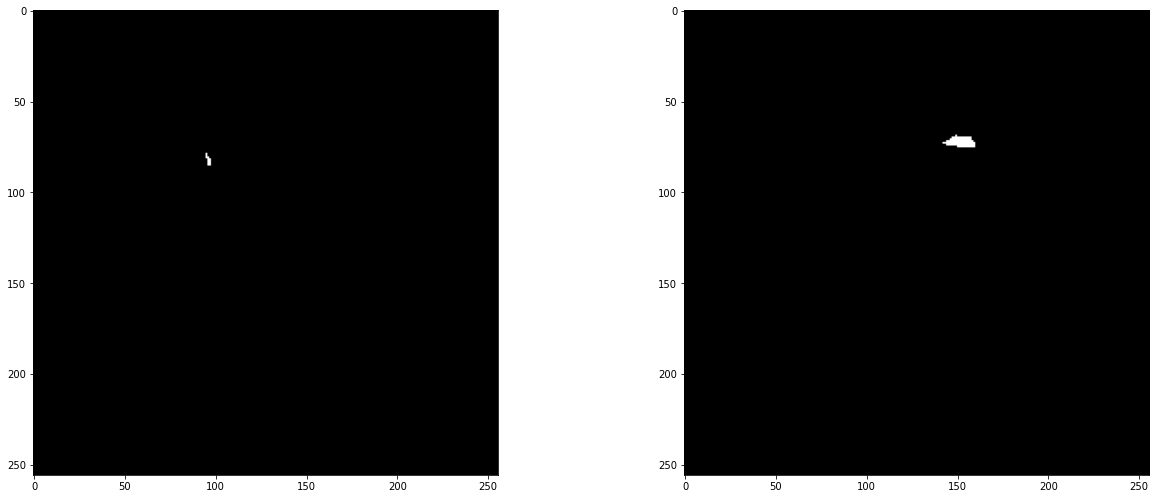

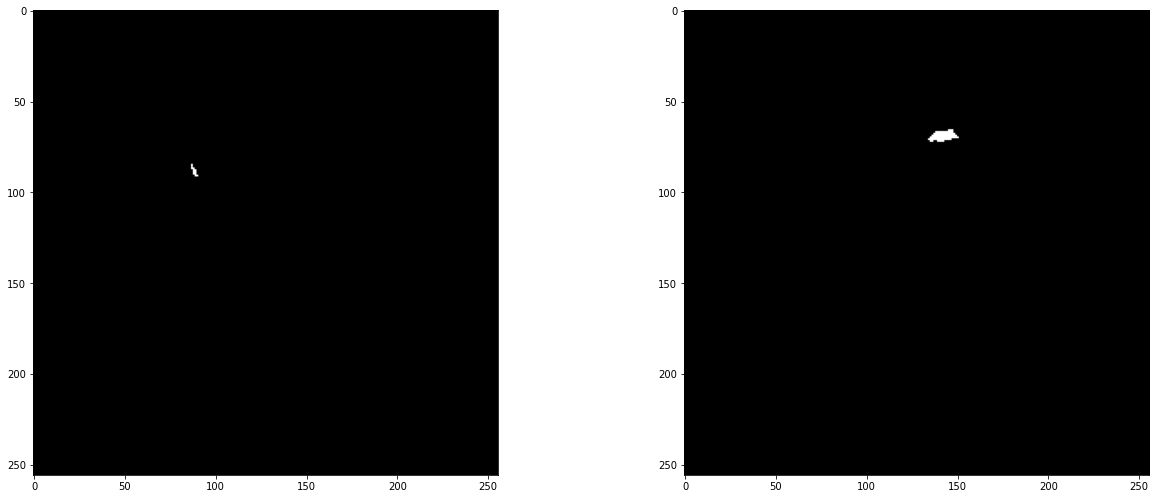

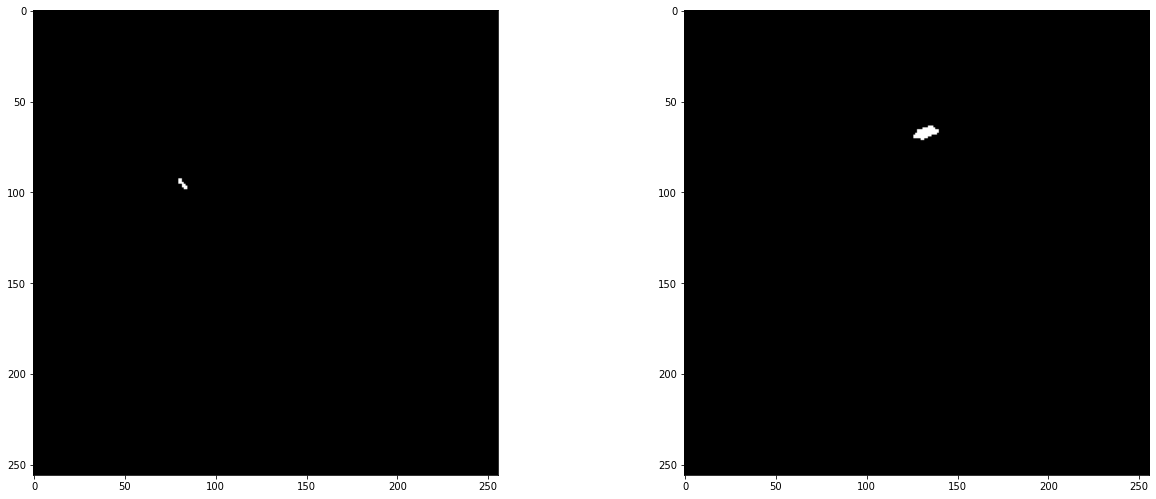

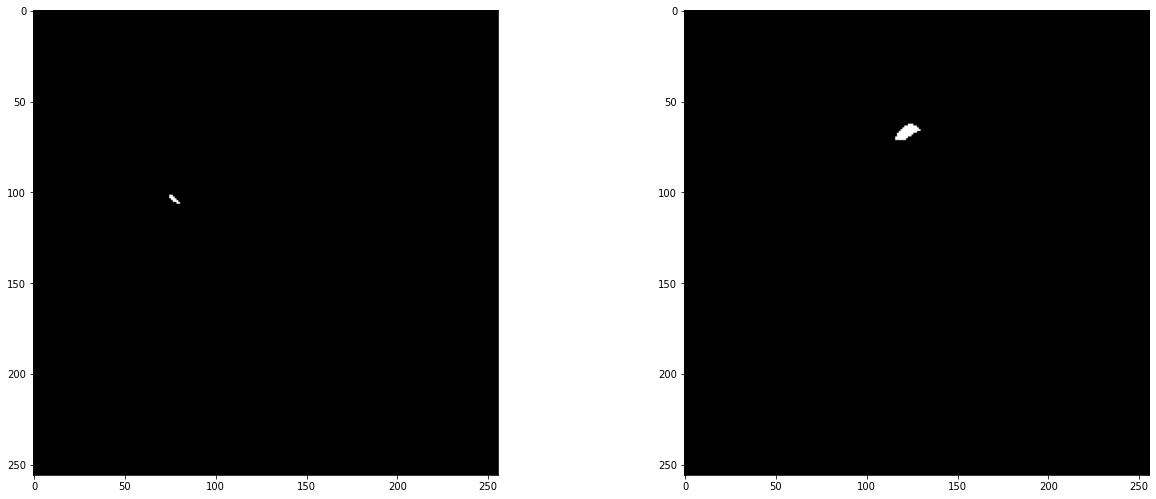

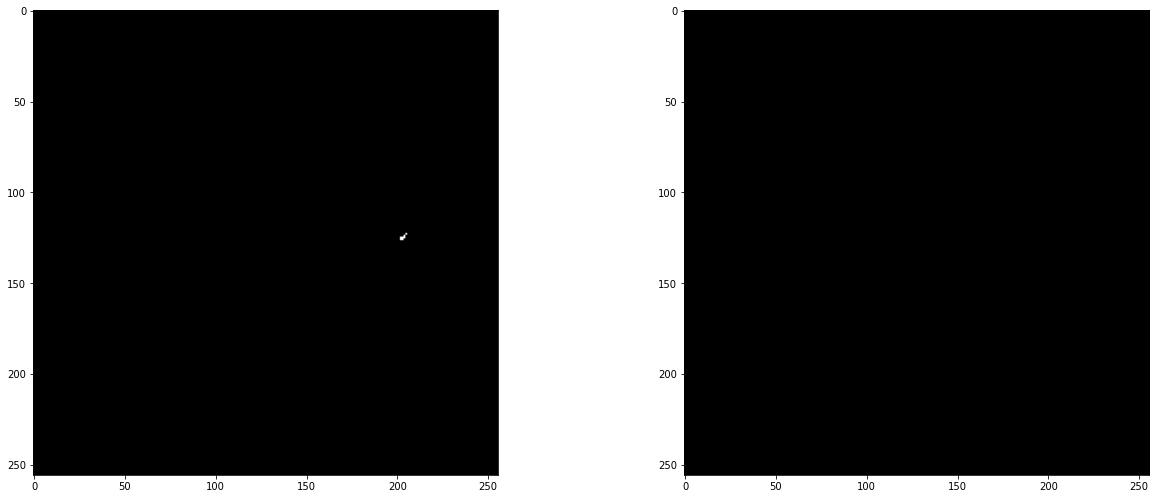

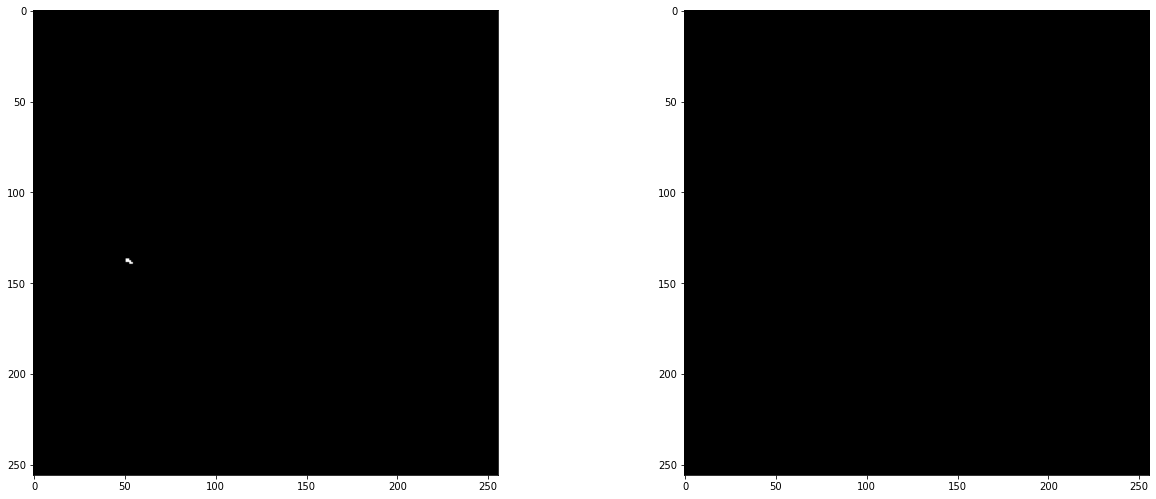

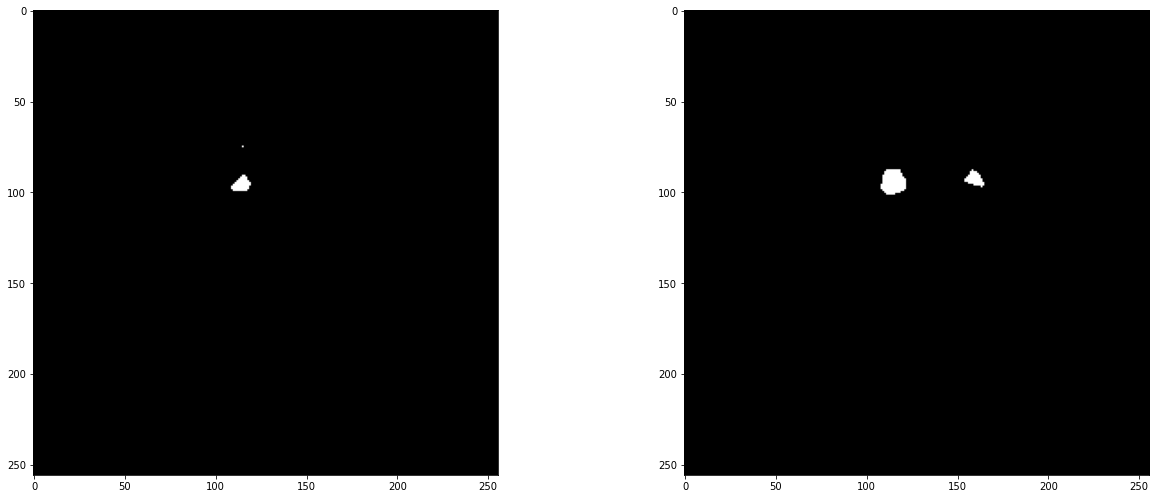

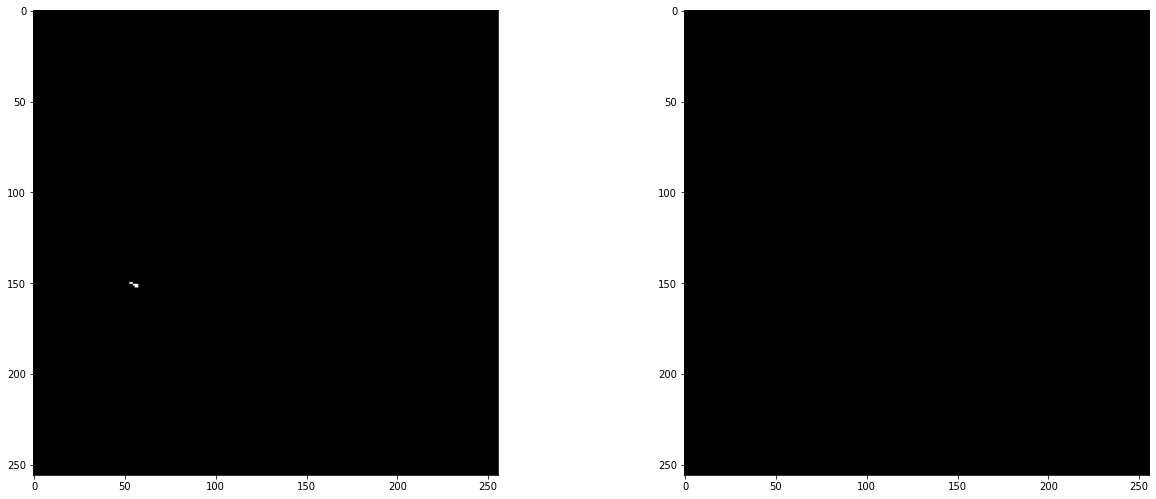

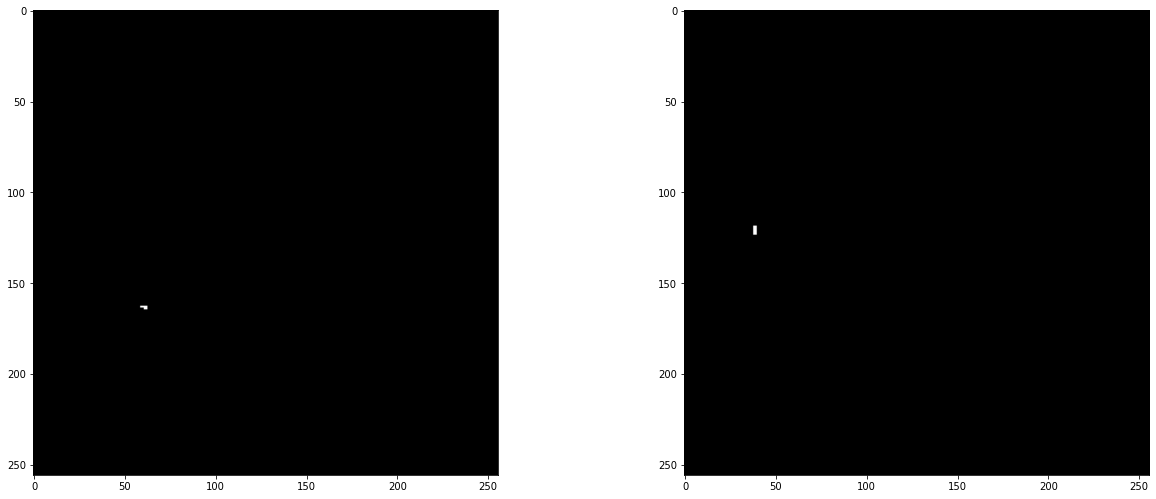

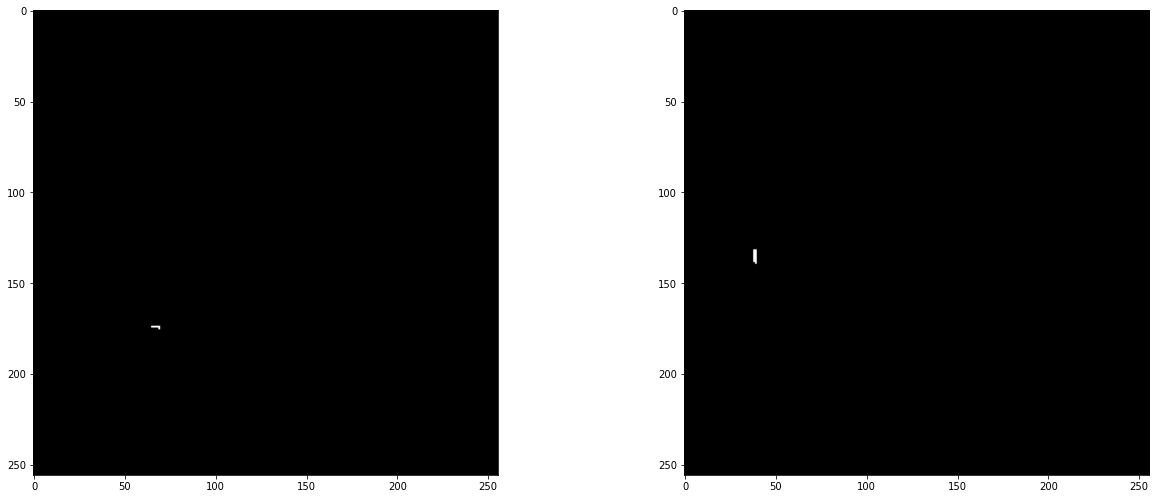

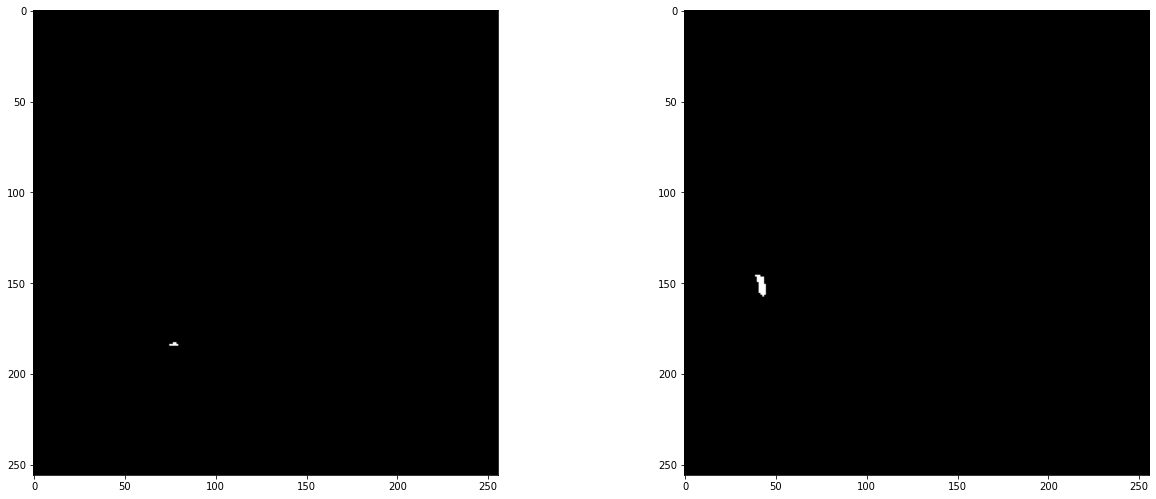

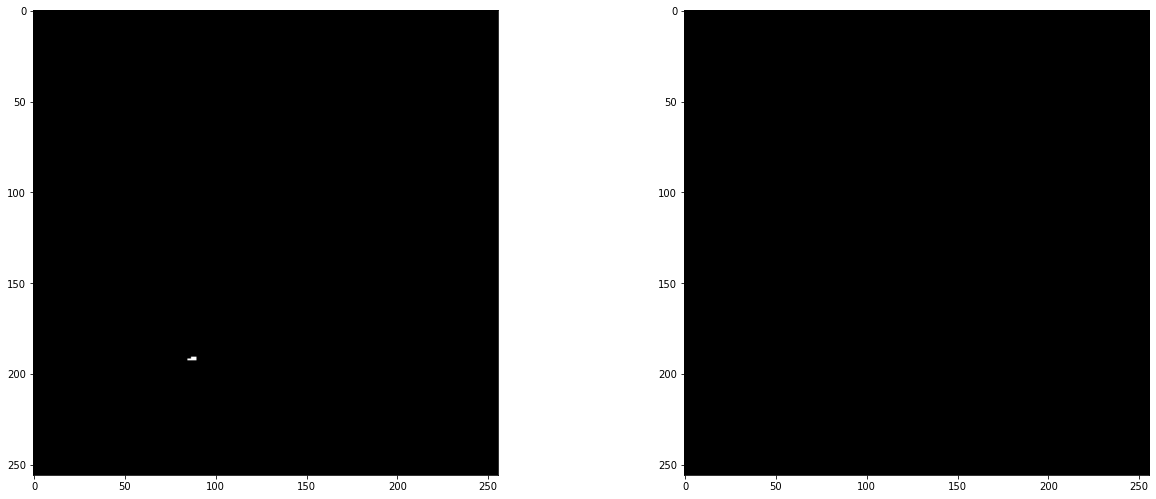

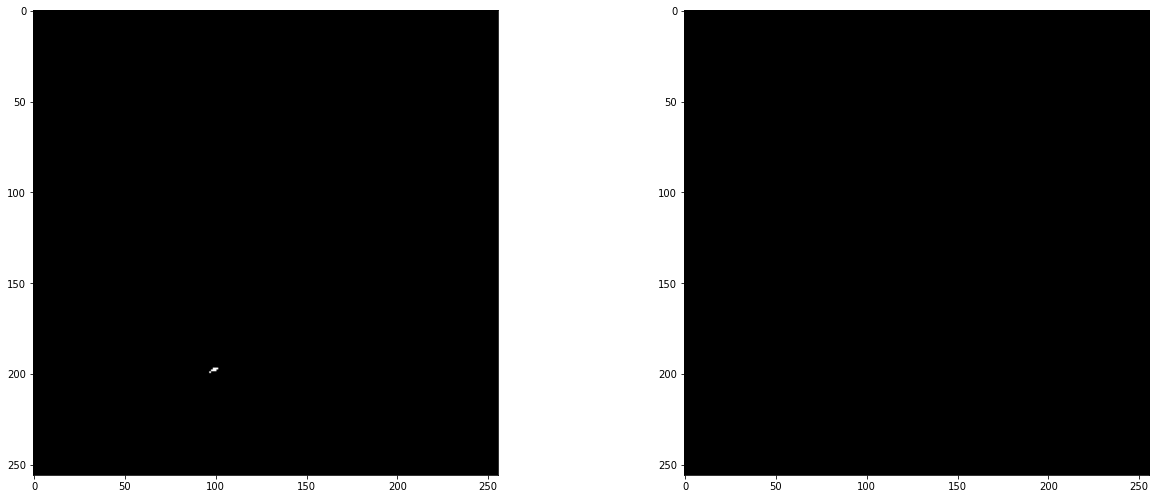

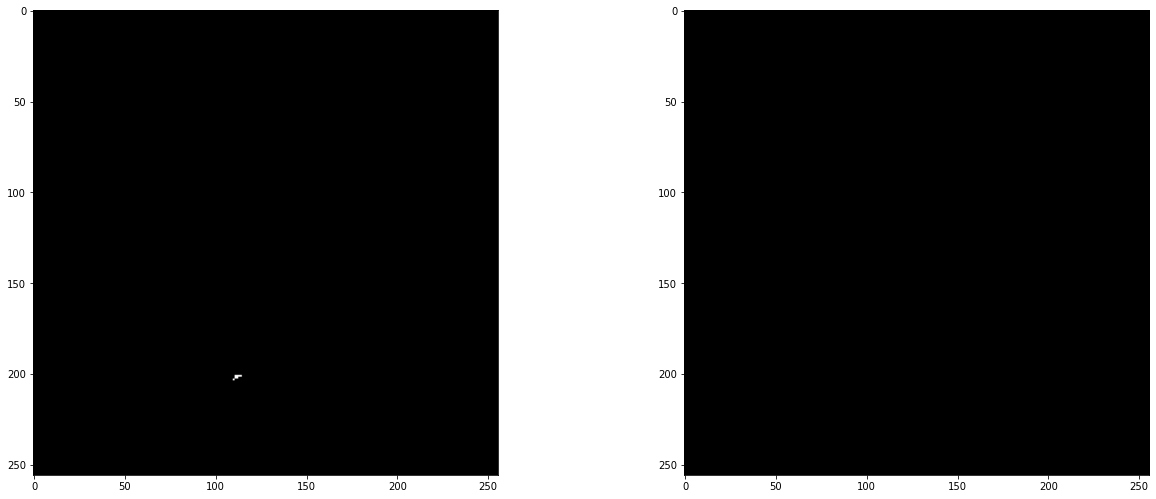

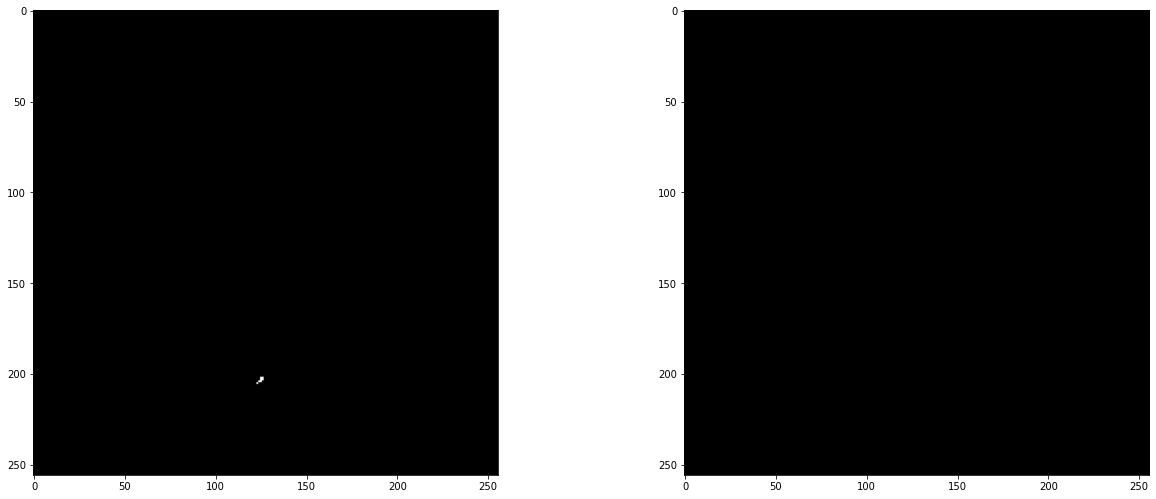

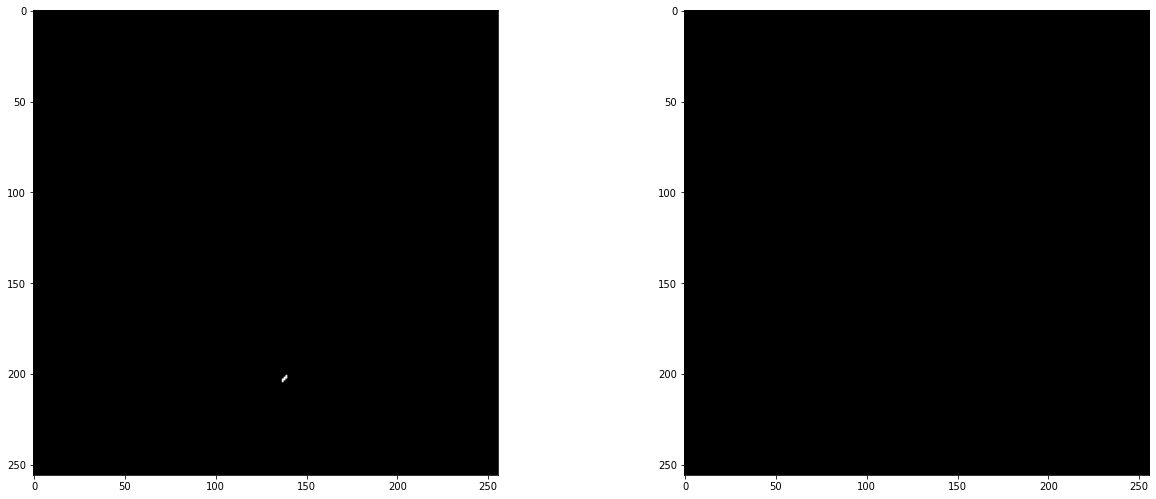

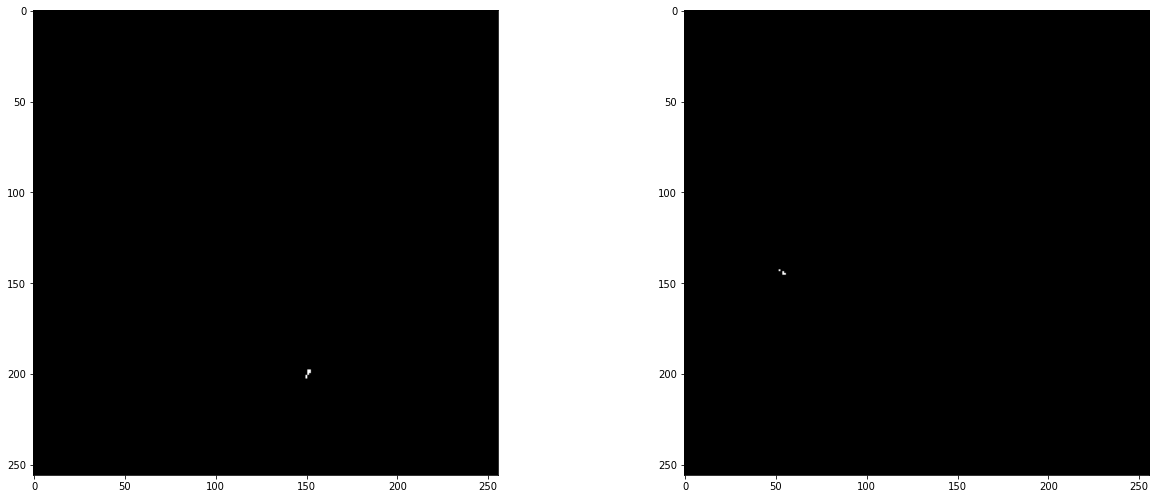

In [18]:
# imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")
for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4
#     print(id_name)
    for j in range(len(result)):
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[j]*255, (image_size, image_size)), cmap="gray")
#         ax.imshow(y[i])
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[j]*255, (image_size, image_size)), cmap="gray")

4
2
(16, 256, 256, 3)
(16, 256, 256, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 3568 61955]
 [    0    13]]
[ 3568 61955     0    13]


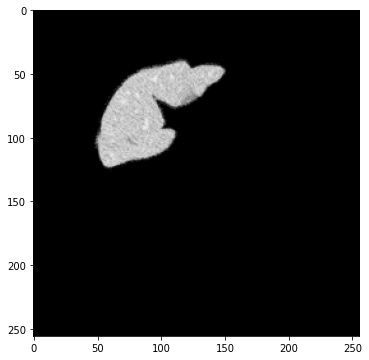

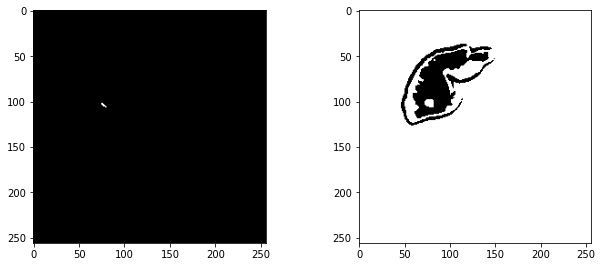

In [20]:
random_batch = random.randint(0, len(valid_ids)//batch_size - 1)
random_sample = random.randint(0, batch_size-1)
random_batch = 4
random_sample = 2
print(random_batch)
print(random_sample)
x, y = valid_gen.__getitem__(random_batch)
print(x.shape)
print(y.shape)
result =  model.predict(x)
result = result > 0

fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(1,1,1)
ax2.imshow(x[random_sample])

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
#         ax.imshow(y[i])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[random_sample]*255, (image_size, image_size)), cmap="gray")

# imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
cm_2d = confusion_matrix(y[random_sample].flatten(), result[random_sample].flatten())
cm = cm_2d.ravel()

# (tn, fp, fn, tp)
print(cm_2d)
print(cm)

In [21]:
print("Pixel Accuracy " + str(((cm[3]+cm[0])/(cm[3]+cm[0]+cm[1]+cm[2])*100))+'%' )
print("True Positive Accuracy " + str(((cm[3])/(cm[3]+cm[2])*100))+'%' )
print("Dice Coefficient " + str(dice(y[random_sample], result[random_sample])))


Pixel Accuracy 5.46417236328125%
True Positive Accuracy 100.0%
Dice Coefficient 0.00041948339007115084


C:\Users\Kedaresh\AppData\Local\Temp\ipykernel_10176\747253369.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
C:\Users\Kedaresh\AppData\Local\Temp\ipykernel_10176\747253369.py:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)


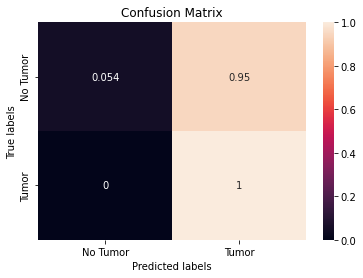

In [22]:
ax= plt.subplot()
cm_2d = cm_2d.astype('float') / cm_2d.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_2d, annot=True, ax = ax); #annot=True to annotate cells

#print(count_cms)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Tumor', 'Tumor']); ax.yaxis.set_ticklabels(['No Tumor', 'Tumor']);

